# 工程采样

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('data/mcm_processed_data.csv', low_memory=False)
df.head()

## 位置信息

In [ ]:
letter_freq_mean = df['letter_freq_mean']
letter_freq_min = df['letter_freq_min']
letter_commonness = df['letter_commonness']
Zipf_value = df['Zipf-value']

In [ ]:
plt.figure(figsize=(6, 8), dpi=600)
plt.subplot(2, 1, 1)
plt.scatter(letter_freq_mean, letter_freq_min)
plt.xlabel('Mean Letter Frequency')
plt.ylabel('Min Letter Frequency')

plt.subplot(2, 1, 2)
plt.scatter(letter_commonness, letter_freq_mean)
plt.xlabel('Letter Commonness')
plt.ylabel('Mean Letter Frequency')

plt.tight_layout()
plt.show()

In [ ]:
## 线性加权降维：Mean Letter Frequency 和 Min Letter Frequency
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体
# 方法1：等权重线性加权
# 使用0.5和0.5的权重将两个特征合并
df['letter_freq_combined'] = 0.5 * letter_freq_mean + 0.5 * letter_freq_min

# 方法2：基于方差的权重（可选）
# 根据特征的方差来设置权重，方差大的特征权重更大
var_mean = letter_freq_mean.var()
var_min = letter_freq_min.var()
total_var = var_mean + var_min
weight_mean = var_mean / total_var
weight_min = var_min / total_var
df['letter_freq_combined_weighted'] = weight_mean * letter_freq_mean + weight_min * letter_freq_min

print(f"Mean Letter Frequency 方差: {var_mean:.6f}")
print(f"Min Letter Frequency 方差: {var_min:.6f}")
print(f"等权重组合特征: letter_freq_combined")
print(f"方差加权组合特征: letter_freq_combined_weighted (权重: mean={weight_mean:.4f}, min={weight_min:.4f})")

# 可视化对比
plt.figure(figsize=(12, 5), dpi=600)

plt.subplot(1, 2, 1)
plt.scatter(letter_freq_mean, letter_freq_min, alpha=0.5)
plt.xlabel('Mean Letter Frequency')
plt.ylabel('Min Letter Frequency')
plt.title('原始二维特征分布')

plt.subplot(1, 2, 2)
plt.hist(df['letter_freq_combined'], bins=50, alpha=0.7, label='等权重组合')
plt.hist(df['letter_freq_combined_weighted'], bins=50, alpha=0.7, label='方差加权组合')
plt.xlabel('Combined Letter Frequency')
plt.ylabel('Frequency')
plt.title('降维后的一维特征分布')
plt.legend()

plt.tight_layout()
plt.show()

# 显示统计信息
print("\n降维后特征统计信息:")
print(df[['letter_freq_combined', 'letter_freq_combined_weighted']].describe())


In [ ]:
## 使用交叉验证找到最优权重（针对预测 autoencoder_value）

from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# 检查 autoencoder_value 是否存在
if 'autoencoder_value' not in df.columns:
    raise ValueError("数据中不存在 'autoencoder_value' 列")

# 准备数据
y = df['autoencoder_value'].values
X_mean = letter_freq_mean.values.reshape(-1, 1)
X_min = letter_freq_min.values.reshape(-1, 1)

# 移除缺失值
mask = ~(np.isnan(y) | np.isnan(X_mean).any(axis=1) | np.isnan(X_min).any(axis=1))
y_clean = y[mask]
X_mean_clean = X_mean[mask]
X_min_clean = X_min[mask]

print(f"数据点总数: {len(y)}")
print(f"有效数据点: {len(y_clean)}")
print(f"autoencoder_value 统计信息:")
print(f"  均值: {y_clean.mean():.6f}, 标准差: {y_clean.std():.6f}")

# 设置交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 测试不同的权重组合
weights_mean = np.arange(0, 1.01, 0.05)  # 从0到1，步长0.05
results = []

print("\n开始交叉验证搜索最优权重...")
for w_mean in weights_mean:
    w_min = 1 - w_mean
    
    # 创建组合特征
    X_combined = w_mean * X_mean_clean + w_min * X_min_clean
    
    # 标准化特征
    scaler = StandardScaler()
    X_combined_scaled = scaler.fit_transform(X_combined)
    
    # 使用线性回归进行交叉验证
    model = LinearRegression()
    cv_scores = cross_val_score(model, X_combined_scaled, y_clean, 
                                cv=kf, scoring='r2', n_jobs=-1)
    
    # 计算MSE
    mse_scores = -cross_val_score(model, X_combined_scaled, y_clean, 
                                  cv=kf, scoring='neg_mean_squared_error', n_jobs=-1)
    
    results.append({
        'weight_mean': w_mean,
        'weight_min': w_min,
        'r2_mean': cv_scores.mean(),
        'r2_std': cv_scores.std(),
        'mse_mean': mse_scores.mean(),
        'mse_std': mse_scores.std()
    })

# 转换为DataFrame便于分析
results_df = pd.DataFrame(results)

# 找到最优权重（R²最高）
best_idx = results_df['r2_mean'].idxmax()
best_weight_mean = results_df.loc[best_idx, 'weight_mean']
best_weight_min = results_df.loc[best_idx, 'weight_min']
best_r2 = results_df.loc[best_idx, 'r2_mean']
best_mse = results_df.loc[best_idx, 'mse_mean']

print(f"\n{'='*60}")
print(f"最优权重组合:")
print(f"  Mean Letter Frequency 权重: {best_weight_mean:.4f}")
print(f"  Min Letter Frequency 权重: {best_weight_min:.4f}")
print(f"  交叉验证 R² 得分: {best_r2:.6f} ± {results_df.loc[best_idx, 'r2_std']:.6f}")
print(f"  交叉验证 MSE: {best_mse:.6f} ± {results_df.loc[best_idx, 'mse_std']:.6f}")
print(f"{'='*60}")

# 应用最优权重创建特征
df['letter_freq_combined_optimal'] = best_weight_mean * letter_freq_mean + best_weight_min * letter_freq_min

# 可视化结果
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=600)

# 1. R²得分随权重变化
axes[0, 0].plot(results_df['weight_mean'], results_df['r2_mean'], 'b-', linewidth=2, label='R²均值')
axes[0, 0].fill_between(results_df['weight_mean'], 
                        results_df['r2_mean'] - results_df['r2_std'],
                        results_df['r2_mean'] + results_df['r2_std'],
                        alpha=0.3, color='blue')
axes[0, 0].axvline(best_weight_mean, color='r', linestyle='--', linewidth=2, label=f'最优权重={best_weight_mean:.3f}')
axes[0, 0].set_xlabel('Mean Letter Frequency 权重')
axes[0, 0].set_ylabel('交叉验证 R² 得分')
axes[0, 0].set_title('R²得分随权重变化')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# 2. MSE随权重变化
axes[0, 1].plot(results_df['weight_mean'], results_df['mse_mean'], 'g-', linewidth=2, label='MSE均值')
axes[0, 1].fill_between(results_df['weight_mean'], 
                        results_df['mse_mean'] - results_df['mse_std'],
                        results_df['mse_mean'] + results_df['mse_std'],
                        alpha=0.3, color='green')
axes[0, 1].axvline(best_weight_mean, color='r', linestyle='--', linewidth=2, label=f'最优权重={best_weight_mean:.3f}')
axes[0, 1].set_xlabel('Mean Letter Frequency 权重')
axes[0, 1].set_ylabel('交叉验证 MSE')
axes[0, 1].set_title('MSE随权重变化')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. 最优组合特征与目标变量的关系
axes[1, 0].scatter(df['letter_freq_combined_optimal'], df['autoencoder_value'], 
                   alpha=0.5, s=20)
axes[1, 0].set_xlabel('最优组合特征 (letter_freq_combined_optimal)')
axes[1, 0].set_ylabel('autoencoder_value')
axes[1, 0].set_title(f'最优组合特征 vs autoencoder_value (R²={best_r2:.4f})')
axes[1, 0].grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(df['letter_freq_combined_optimal'].dropna(), 
               df['autoencoder_value'].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(df['letter_freq_combined_optimal'].min(), 
                      df['letter_freq_combined_optimal'].max(), 100)
axes[1, 0].plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='趋势线')
axes[1, 0].legend()

# 4. 权重对比：等权重 vs 最优权重
# 计算方差加权权重（用于对比）
var_mean_val = letter_freq_mean.var()
var_min_val = letter_freq_min.var()
total_var_val = var_mean_val + var_min_val
variance_weight_mean = var_mean_val / total_var_val if total_var_val > 0 else 0.5

# 找到等权重和方差加权对应的R²得分
equal_weight_r2 = results_df[results_df['weight_mean'] == 0.5]['r2_mean'].values[0] if len(results_df[results_df['weight_mean'] == 0.5]) > 0 else 0
# 找到最接近方差加权权重的R²得分
closest_variance_idx = (results_df['weight_mean'] - variance_weight_mean).abs().idxmin()
variance_weight_r2 = results_df.loc[closest_variance_idx, 'r2_mean']

axes[1, 1].bar(['等权重\n(0.5, 0.5)', f'方差加权\n({variance_weight_mean:.2f}, {1-variance_weight_mean:.2f})', f'最优权重\n({best_weight_mean:.2f}, {best_weight_min:.2f})'], 
               [equal_weight_r2, variance_weight_r2, best_r2],
               color=['skyblue', 'lightgreen', 'coral'], alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1, 1].set_ylabel('交叉验证 R² 得分')
axes[1, 1].set_title('不同权重方法的预测效果对比')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 显示前5个最优权重组合
print("\n前5个最优权重组合:")
print(results_df.nlargest(5, 'r2_mean')[['weight_mean', 'weight_min', 'r2_mean', 'mse_mean']].to_string(index=False))


# 总体特征工程

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv('data/mcm_processed_data.csv', low_memory=False)
df.head()

date  contest_number   word  number_of_reported_results  \
0  2022/12/31             560  manly                       20380   
1  2022/12/30             559  molar                       21204   
2  2022/12/29             558  havoc                       20001   
3  2022/12/28             557  impel                       20160   
4  2022/12/27             556  condo                       20879   

   number_in_hard_mode  1_try  2_tries  3_tries  4_tries  5_tries  ...  \
0                 1899      0        2       17       37       29  ...   
1                 1973      0        4       21       38       26  ...   
2                 1919      0        2       16       38       30  ...   
3                 1937      0        3       21       40       25  ...   
4                 2012      0        2       17       35       29  ...   

   semantic_distance_to_center  rl_1_try_little_training  \
0                     6.525427                     0.000   
1                     8.467040                     0.000   
2                     6.983014                     0.002   
3                     6.068421                     0.002   
4                     6.873646                     0.000   

   rl_2_try_little_training  rl_3_try_little_training  \
0                     0.132                     0.366   
1                     0.110                     0.382   
2                     0.122                     0.352   
3                     0.128                     0.368   
4                     0.116                     0.428   

   rl_4_try_little_training  rl_5_try_little_training  \
0                     0.350                     0.128   
1                     0.362                     0.130   
2                     0.350                     0.160   
3                     0.354                     0.122   
4                     0.370                     0.080   

   rl_6_try_little_training  rl_7_try_little_training  \
0                     0.022                     0.002   
1                     0.014                     0.002   
2                     0.014                     0.000   
3                     0.026                     0.000   
4                     0.006                     0.000   

   rl_expected_steps_little_training  feedback_entropy  
0                              3.548          4.946671  
1                              3.562          5.277828  
2                              3.586          4.235738  
3                              3.544          4.500769  
4                              3.432          4.037916  

[5 rows x 92 columns]

In [2]:

feature_categories = {
    '使用特征': [
        'Zipf-value',             # Zipf频率值
    ],
    '字母组合特征': [
        'letter_entropy',        # 字母熵
        'hamming_neighbors',     # 汉明距离邻居数
    ],
    '反馈特征': [
        'feedback_entropy',      # 反馈熵
    ],
    '音节特征': [
        'num_consonants',        # 辅音字母数量
        'max_consecutive_vowels',      # 最大连续元音数
        'max_consecutive_consonants',  # 最大连续辅音数
        'starts_with_vowel',      # 是否以元音开头
        'ends_with_vowel'         # 是否以元音结尾
    ],
    '字母频率特征': [
        'letter_freq_mean',      # 字母平均频率
        'letter_freq_min',        # 字母最小频率
        'letter_commonness',      # 字母常见度
        'contains_y',            # 是否包含字母Y
        'has_double_letter',     # 是否有重复字母
        'scrabble_score',        # Scrabble分数
        'has_common_suffix',     # 是否有常见后缀
        'has_common_prefix',      # 是否有常见前缀
        'num_rare_letters'        # 罕见字母数量
    ],
    '位置特征': [
        'position_rarity',        # 位置稀有度
        'positional_freq_mean',   # 位置频率均值
        'positional_freq_min',    # 位置频率最小值
        'positional_fit',         # 位置拟合度
        'position_self_entropy',            # 位置自熵
        'position_self_entropy_2_letters',  # 两字母位置熵
    ],
    '键盘距离特征': [
        'keyboard_distance'       # 键盘输入距离
    ],
    '语义特征': [
        'semantic_neighbors_count',    # 语义邻居数量
        'semantic_density',            # 语义密度
        'semantic_distance',           # 语义距离（余弦相似度）
        'semantic_distance_to_center'  # 到语义中心的距离
    ],
    '仿真模拟特征': [
        # 随机策略模拟
        'mean_simulate_random',   # 随机策略平均尝试次数
        # '1_try_simulate_random',  # 随机策略1次尝试概率
        # '2_try_simulate_random',  # 随机策略2次尝试概率
        # '3_try_simulate_random',  # 随机策略3次尝试概率
        # '4_try_simulate_random',  # 随机策略4次尝试概率
        # '5_try_simulate_random',  # 随机策略5次尝试概率
        # '6_try_simulate_random',  # 随机策略6次尝试概率
        # '7_try_simulate_random',  # 随机策略7次尝试概率
        # 频率策略模拟
        'mean_simulate_freq',     # 频率策略平均尝试次数
        # '1_try_simulate_freq',    # 频率策略1次尝试概率
        # '2_try_simulate_freq',    # 频率策略2次尝试概率
        # '3_try_simulate_freq',    # 频率策略3次尝试概率
        # '4_try_simulate_freq',    # 频率策略4次尝试概率
        # '5_try_simulate_freq',    # 频率策略5次尝试概率
        # '6_try_simulate_freq',    # 频率策略6次尝试概率
        # '7_try_simulate_freq',    # 频率策略7次尝试概率
        # 熵策略模拟
        'mean_simulate_entropy',  # 熵策略平均尝试次数
        # '1_try_simulate_entropy', # 熵策略1次尝试概率
        # '2_try_simulate_entropy', # 熵策略2次尝试概率
        # '3_try_simulate_entropy', # 熵策略3次尝试概率
        # '4_try_simulate_entropy', # 熵策略4次尝试概率
        # '5_try_simulate_entropy', # 熵策略5次尝试概率
        # '6_try_simulate_entropy', # 熵策略6次尝试概率
        # '7_try_simulate_entropy'  # 熵策略7次尝试概率
    ],
    '熵特征': [
        
    ],
    '强化学习特征': [
        # 低训练水平
        'rl_expected_steps_low_training',   # 低训练水平期望步数
        # 'rl_1_try_low_training',            # 低训练水平1次尝试概率
        # 'rl_2_try_low_training',            # 低训练水平2次尝试概率
        # 'rl_3_try_low_training',            # 低训练水平3次尝试概率
        # 'rl_4_try_low_training',            # 低训练水平4次尝试概率
        # 'rl_5_try_low_training',            # 低训练水平5次尝试概率
        # 'rl_6_try_low_training',            # 低训练水平6次尝试概率
        # 'rl_7_try_low_training',            # 低训练水平7次尝试概率
        # 高训练水平
        'rl_expected_steps_high_training',   # 高训练水平期望步数
        # 'rl_1_try_high_training',           # 高训练水平1次尝试概率
        # 'rl_2_try_high_training',           # 高训练水平2次尝试概率
        # 'rl_3_try_high_training',           # 高训练水平3次尝试概率
        # 'rl_4_try_high_training',           # 高训练水平4次尝试概率
        # 'rl_5_try_high_training',           # 高训练水平5次尝试概率
        # 'rl_6_try_high_training',           # 高训练水平6次尝试概率
        # 'rl_7_try_high_training',           # 高训练水平7次尝试概率
        # 少量训练水平
        'rl_expected_steps_little_training', # 少量训练水平期望步数
        # 'rl_1_try_little_training',          # 少量训练水平1次尝试概率
        # 'rl_2_try_little_training',          # 少量训练水平2次尝试概率
        # 'rl_3_try_little_training',          # 少量训练水平3次尝试概率
        # 'rl_4_try_little_training',          # 少量训练水平4次尝试概率
        # 'rl_5_try_little_training',          # 少量训练水平5次尝试概率
        # 'rl_6_try_little_training',          # 少量训练水平6次尝试概率
        # 'rl_7_try_little_training'           # 少量训练水平7次尝试概率
    ]
}

target_feature = 'autoencoder_value'

In [3]:
df['mean_simulate_random'] = 1 * df['1_try_simulate_random'] + 2 * df['2_try_simulate_random'] + 3 * df['3_try_simulate_random'] + 4 * df['4_try_simulate_random'] + 5 * df['5_try_simulate_random'] + 6 * df['6_try_simulate_random'] + 9 * df['7_try_simulate_random']
df['mean_simulate_freq'] = 1 * df['1_try_simulate_freq'] + 2 * df['2_try_simulate_freq'] + 3 * df['3_try_simulate_freq'] + 4 * df['4_try_simulate_freq'] + 5 * df['5_try_simulate_freq'] + 6 * df['6_try_simulate_freq'] + 9 * df['7_try_simulate_freq']
df['mean_simulate_entropy'] = 1 * df['1_try_simulate_entropy'] + 2 * df['2_try_simulate_entropy'] + 3 * df['3_try_simulate_entropy'] + 4 * df['4_try_simulate_entropy'] + 5 * df['5_try_simulate_entropy'] + 6 * df['6_try_simulate_entropy'] + 9 * df['7_try_simulate_entropy']

In [4]:
## 多方法降维分析：针对预测 autoencoder_value

import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA, FactorAnalysis
# ============================================================================
# 降维方法：包含无监督和监督方法
# ============================================================================
# 无监督方法：
#   - PCA (主成分分析): 完全无监督，只基于特征本身的方差
#   - Factor Analysis (因子分析): 完全无监督，基于特征的潜在因子结构
#
# 监督方法（需要在训练集上训练，避免数据泄露）：
#   - CCA (典型相关分析): 考虑目标变量的典型相关关系
#   - PLS (偏最小二乘): 考虑与目标变量的关系
#   - Supervised Linear Weighted: 基于预测效果优化权重
#
# 重要：所有降维方法都将在训练集上训练，然后对测试集进行transform
# ============================================================================
from sklearn.cross_decomposition import CCA, PLSRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from scipy.optimize import minimize
import numpy as np

# 检查目标变量
if target_feature not in df.columns:
    raise ValueError(f"数据中不存在 '{target_feature}' 列")

y = df[target_feature].values

print("="*80)
print("多方法降维分析：针对预测 autoencoder_value")
print("="*80)
print(f"目标变量: {target_feature}")
print(f"数据点总数: {len(y)}")
print(f"有效数据点: {np.sum(~np.isnan(y))}")
print(f"目标变量统计: 均值={np.nanmean(y):.6f}, 标准差={np.nanstd(y):.6f}")
print("="*80)


多方法降维分析：针对预测 autoencoder_value
目标变量: autoencoder_value
数据点总数: 358
有效数据点: 358
目标变量统计: 均值=-0.598737, 标准差=0.457156


In [5]:
## 步骤1.5: 划分训练集和测试集（避免数据泄露）

from sklearn.model_selection import train_test_split

# 准备数据：提取所有原始特征
all_original_features = []
for features in feature_categories.values():
    all_original_features.extend([f for f in features if f in df.columns])
all_original_features = list(set(all_original_features))  # 去重

# 移除目标变量和标识列
X_all = df[all_original_features].copy()
y_all = df[target_feature].copy()

# 移除包含缺失值的行
valid_mask = ~(X_all.isna().any(axis=1) | y_all.isna())
X_clean = X_all[valid_mask].copy()
y_clean = y_all[valid_mask].copy()

print("="*80)
print("数据划分：训练集和测试集")
print("="*80)
print(f"总数据点: {len(X_clean)}")
print(f"特征数量: {len(all_original_features)}")

# 划分训练集和测试集（80-20分割）
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, 
    test_size=0.2, 
    random_state=42,
    shuffle=True
)

print(f"\n训练集大小: {len(X_train)} ({len(X_train)/len(X_clean)*100:.1f}%)")
print(f"测试集大小: {len(X_test)} ({len(X_test)/len(X_clean)*100:.1f}%)")
print(f"\n⚠️ 重要：所有降维模型都将在训练集上训练，然后对测试集进行transform")
print("="*80)

# 创建训练集和测试集的DataFrame（保留word列用于后续合并）
if 'word' in df.columns:
    train_df = df.loc[X_train.index].copy()
    test_df = df.loc[X_test.index].copy()
else:
    train_df = X_train.copy()
    train_df[target_feature] = y_train
    test_df = X_test.copy()
    test_df[target_feature] = y_test

print(f"\n训练集DataFrame形状: {train_df.shape}")
print(f"测试集DataFrame形状: {test_df.shape}")


数据划分：训练集和测试集
总数据点: 354
特征数量: 35

训练集大小: 283 (79.9%)
测试集大小: 71 (20.1%)

⚠️ 重要：所有降维模型都将在训练集上训练，然后对测试集进行transform

训练集DataFrame形状: (283, 92)
测试集DataFrame形状: (71, 92)


In [6]:
## 步骤1: 定义评估函数和降维方法

def evaluate_reduced_features(X_reduced, y_target, method_name='', n_components=None):
    """
    评估降维后特征对目标变量的预测效果
    
    参数:
    - X_reduced: 降维后的特征矩阵
    - y_target: 目标变量
    - method_name: 方法名称
    - n_components: 主成分数量（用于解释性分析）
    
    返回:
    - 包含R²、MSE等指标的字典
    """
    # 移除缺失值
    if X_reduced.ndim == 1:
        mask = ~(np.isnan(X_reduced) | np.isnan(y_target))
        X_clean = X_reduced[mask].reshape(-1, 1)
    else:
        mask = ~(np.isnan(X_reduced).any(axis=1) | np.isnan(y_target))
        X_clean = X_reduced[mask]
    
    y_clean = y_target[mask]
    
    if len(X_clean) < 10:
        return {
            'r2_mean': -np.inf, 
            'r2_std': 0, 
            'mse_mean': np.inf, 
            'mse_std': 0,
            'n_samples': len(X_clean)
        }
    
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    # 交叉验证
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = LinearRegression()
    
    cv_r2 = cross_val_score(model, X_scaled, y_clean, cv=kf, scoring='r2', n_jobs=-1)
    cv_mse = -cross_val_score(model, X_scaled, y_clean, cv=kf, 
                              scoring='neg_mean_squared_error', n_jobs=-1)
    
    return {
        'r2_mean': cv_r2.mean(),
        'r2_std': cv_r2.std(),
        'mse_mean': cv_mse.mean(),
        'mse_std': cv_mse.std(),
        'n_samples': len(X_clean)
    }

def apply_pca(X, n_components=None, max_components=None):
    """应用PCA降维，返回降维后的数据和解释性信息"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = min(max_components or X.shape[1], X.shape[1], X.shape[0]-1)
    
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X_scaled)
    
    return {
        'reduced_data': X_reduced,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'components': pca.components_,
        'scaler': scaler,
        'pca': pca,
        'interpretability': {
            'method': 'PCA',
            'n_components': n_components,
            'explained_variance': pca.explained_variance_ratio_.sum(),
            'component_loadings': pca.components_  # 主成分载荷，用于解释
        }
    }

def apply_cca(X, y, n_components=None, max_components=None):
    """应用CCA（典型相关分析）降维，考虑目标变量"""
    # 移除缺失值
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask].reshape(-1, 1)
    
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_clean)
    y_scaled = scaler_y.fit_transform(y_clean)
    
    if n_components is None:
        n_components = min(max_components or X.shape[1], X.shape[1], X.shape[0]-1, 1)
    
    cca = CCA(n_components=n_components)
    X_reduced, y_reduced = cca.fit_transform(X_scaled, y_scaled)
    
    # 计算典型相关系数
    if X_reduced.ndim > 1:
        canonical_corrs = [np.corrcoef(X_reduced[:, i], y_reduced[:, i])[0, 1] 
                          for i in range(n_components)]
    else:
        canonical_corrs = [np.corrcoef(X_reduced, y_reduced.flatten())[0, 1]]
    
    return {
        'reduced_data': X_reduced,
        'canonical_correlations': canonical_corrs,
        'x_loadings': cca.x_loadings_,
        'scaler': scaler_X,
        'cca': cca,
        'interpretability': {
            'method': 'CCA',
            'n_components': n_components,
            'canonical_correlations': canonical_corrs,
            'x_loadings': cca.x_loadings_  # X变量的载荷，用于解释
        }
    }

def apply_pls(X, y, n_components=None, max_components=None):
    """应用PLS（偏最小二乘）降维，监督方法"""
    # 移除缺失值
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask]
    
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_clean)
    
    if n_components is None:
        n_components = min(max_components or X.shape[1], X.shape[1], X.shape[0]-1)
    
    pls = PLSRegression(n_components=n_components)
    pls.fit(X_scaled, y_clean)
    X_reduced = pls.transform(X_scaled)
    
    return {
        'reduced_data': X_reduced,
        'x_loadings': pls.x_loadings_,
        'y_loadings': pls.y_loadings_,
        'scaler': scaler_X,
        'pls': pls,
        'interpretability': {
            'method': 'PLS',
            'n_components': n_components,
            'x_loadings': pls.x_loadings_,  # X变量的载荷
            'y_loadings': pls.y_loadings_  # Y变量的载荷，显示与目标的关系
        }
    }

def apply_factor_analysis(X, n_components=None, max_components=None):
    """应用因子分析降维"""
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if n_components is None:
        n_components = min(max_components or X.shape[1], X.shape[1], X.shape[0]-1)
    
    fa = FactorAnalysis(n_components=n_components, random_state=42)
    X_reduced = fa.fit_transform(X_scaled)
    
    return {
        'reduced_data': X_reduced,
        'components': fa.components_,
        'noise_variance': fa.noise_variance_,
        'scaler': scaler,
        'fa': fa,
        'interpretability': {
            'method': 'Factor Analysis',
            'n_components': n_components,
            'factor_loadings': fa.components_  # 因子载荷，用于解释
        }
    }

def apply_supervised_linear_weighted(X, y, feature_names=None):
    """应用监督线性加权降维（基于预测效果优化权重）"""
    # 移除缺失值
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    def objective(weights_normalized):
        """优化目标：最大化交叉验证R²"""
        weights = weights_normalized / (weights_normalized.sum() + 1e-10)  # 归一化
        X_combined = X_scaled @ weights
        
        model = LinearRegression()
        cv_r2 = cross_val_score(model, X_combined.reshape(-1, 1), y_clean, 
                               cv=kf, scoring='r2', n_jobs=-1)
        return -cv_r2.mean()  # 最小化负R²
    
    # 初始权重（等权重）
    initial_weights = np.ones(X_scaled.shape[1]) / X_scaled.shape[1]
    
    # 优化权重
    bounds = [(0, 1) for _ in range(X_scaled.shape[1])]
    result = minimize(objective, initial_weights, method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        optimal_weights = result.x / result.x.sum()
        optimal_r2 = -result.fun
    else:
        # 如果优化失败，使用等权重
        optimal_weights = initial_weights
        X_combined = X_scaled @ optimal_weights
        eval_result = evaluate_reduced_features(X_combined, y_clean)
        optimal_r2 = eval_result['r2_mean']
    
    X_reduced = X_scaled @ optimal_weights
    
    return {
        'reduced_data': X_reduced,
        'weights': optimal_weights,
        'scaler': scaler,
        'interpretability': {
            'method': 'Supervised Linear Weighted',
            'weights': optimal_weights,
            'feature_names': feature_names,
            'weight_dict': dict(zip(feature_names, optimal_weights)) if feature_names else None
        }
    }

def analyze_feature_importance(X, y, feature_names, method='lasso', threshold_percentile=10):
    """
    分析每个特征对目标变量的预测贡献度
    
    参数:
    - X: 特征矩阵 (n_samples, n_features)
    - y: 目标变量 (n_samples,)
    - feature_names: 特征名称列表
    - method: 分析方法 ('lasso', 'correlation', 'mutual_info')
    - threshold_percentile: 贡献度阈值百分位数，低于此值的特征将被过滤
    
    返回:
    - feature_importance: 特征重要性字典 {feature_name: importance_score}
    - filtered_features: 过滤后的特征列表
    - importance_df: 重要性DataFrame
    """
    # 移除缺失值
    mask = ~(np.isnan(X).any(axis=1) | np.isnan(y))
    X_clean = X[mask]
    y_clean = y[mask]
    
    if len(X_clean) < 10:
        return {}, feature_names, pd.DataFrame()
    
    # 标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_clean)
    
    feature_importance = {}
    
    if method == 'lasso':
        # 使用Lasso回归的系数绝对值作为重要性
        try:
            lasso = LassoCV(alphas=np.logspace(-6, 1, 50), cv=5, random_state=42, max_iter=5000)
            lasso.fit(X_scaled, y_clean)
            importances = np.abs(lasso.coef_)
        except:
            # 如果Lasso失败，使用相关系数
            importances = np.array([abs(np.corrcoef(X_scaled[:, i], y_clean)[0, 1]) 
                                   for i in range(X_scaled.shape[1])])
            importances = np.nan_to_num(importances, nan=0.0)
        
    elif method == 'correlation':
        # 使用与目标变量的相关系数绝对值
        importances = np.array([abs(np.corrcoef(X_scaled[:, i], y_clean)[0, 1]) 
                               for i in range(X_scaled.shape[1])])
        importances = np.nan_to_num(importances, nan=0.0)
        
    elif method == 'mutual_info':
        # 使用互信息
        from sklearn.feature_selection import mutual_info_regression
        importances = mutual_info_regression(X_scaled, y_clean, random_state=42)
        
    else:
        # 默认使用Lasso
        try:
            lasso = LassoCV(alphas=np.logspace(-6, 1, 50), cv=5, random_state=42, max_iter=5000)
            lasso.fit(X_scaled, y_clean)
            importances = np.abs(lasso.coef_)
        except:
            importances = np.array([abs(np.corrcoef(X_scaled[:, i], y_clean)[0, 1]) 
                                   for i in range(X_scaled.shape[1])])
            importances = np.nan_to_num(importances, nan=0.0)
    
    # 创建重要性字典
    for i, feat in enumerate(feature_names):
        feature_importance[feat] = importances[i]
    
    # 创建DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'abs_importance': np.abs(importances)
    }).sort_values('abs_importance', ascending=False)
    
    # 计算阈值（保留重要性大于阈值百分位数的特征）
    if len(importance_df) > 1:
        threshold = np.percentile(importance_df['abs_importance'], threshold_percentile)
        # 至少保留1个特征
        filtered_features = importance_df[importance_df['abs_importance'] > threshold]['feature'].tolist()
        if len(filtered_features) == 0:
            # 如果所有特征都被过滤，至少保留最重要的1个
            filtered_features = [importance_df.iloc[0]['feature']]
    else:
        filtered_features = feature_names
    
    return feature_importance, filtered_features, importance_df

print("✅ 降维方法和评估函数已定义")
print("✅ 特征贡献度分析函数已定义")


✅ 降维方法和评估函数已定义
✅ 特征贡献度分析函数已定义


In [7]:
## 步骤1.6: 特征贡献度分析和过滤（在训练集上进行，避免数据泄露）

print("\n" + "="*80)
print("步骤1.6: 特征贡献度分析和过滤")
print("="*80)
print("⚠️ 重要：特征贡献度分析在训练集上进行，避免数据泄露")
print("="*80)

# 存储过滤后的特征组
filtered_feature_categories = {}
feature_importance_results = {}

# 特征贡献度分析的阈值（保留贡献度高于第20百分位数的特征）
importance_threshold_percentile = 20

for group_name, features in feature_categories.items():
    # 检查特征是否存在
    existing_features = [f for f in features if f in X_train.columns]
    
    if len(existing_features) <= 3:
        # 小于3个特征的特征组直接保留，不需要过滤
        filtered_feature_categories[group_name] = existing_features
        if len(existing_features) == 1:
            print(f"\n{group_name}: 只有1个特征 '{existing_features[0]}'，直接保留（无需过滤）")
        continue
    
    print(f"\n{'='*80}")
    print(f"分析特征组: {group_name}")
    print(f"原始特征数量: {len(existing_features)}")
    print(f"特征列表: {existing_features}")
    print(f"{'='*80}")
    
    # 在训练集上分析特征贡献度
    X_group_train = X_train[existing_features].copy()
    y_train_group = y_train.copy()
    
    # 移除缺失值
    mask = ~(X_group_train.isna().any(axis=1) | y_train_group.isna())
    X_group_clean = X_group_train[mask]
    y_group_clean = y_train_group[mask]
    
    if len(X_group_clean) < 10:
        print(f"⚠️ 数据点不足，跳过特征过滤")
        filtered_feature_categories[group_name] = existing_features
        continue
    
    # 分析特征贡献度
    try:
        feature_importance, filtered_features, importance_df = analyze_feature_importance(
            X_group_clean.values, 
            y_group_clean.values,
            existing_features,
            method='lasso',
            threshold_percentile=importance_threshold_percentile
        )
        
        # 保存重要性分析结果
        feature_importance_results[group_name] = {
            'importance_df': importance_df,
            'filtered_features': filtered_features,
            'original_features': existing_features
        }
        
        print(f"\n特征贡献度分析结果（按重要性排序）:")
        print(importance_df.to_string(index=False))
        
        print(f"\n过滤结果:")
        print(f"  原始特征数: {len(existing_features)}")
        print(f"  过滤后特征数: {len(filtered_features)}")
        print(f"  过滤掉的特征数: {len(existing_features) - len(filtered_features)}")
        
        if len(filtered_features) < len(existing_features):
            removed_features = [f for f in existing_features if f not in filtered_features]
            print(f"  被过滤的特征: {removed_features}")
        
        # 保存过滤后的特征
        filtered_feature_categories[group_name] = filtered_features
        
    except Exception as e:
        print(f"⚠️ 特征贡献度分析失败: {str(e)}")
        print(f"   保留所有原始特征")
        filtered_feature_categories[group_name] = existing_features
        continue

print(f"\n{'='*80}")
print("特征贡献度分析和过滤完成！")
print(f"{'='*80}")

## 步骤2: 对每个特征组应用多种降维方法（在训练集上训练，避免数据泄露）

# 存储所有降维结果（训练集和测试集分别存储）
all_reduction_results = {}
all_reduction_models = {}  # 存储训练好的模型

print("\n" + "="*80)
print("步骤2: 开始对每个特征组进行降维分析（在训练集上训练，避免数据泄露）")
print("="*80)
print("⚠️ 重要：所有降维模型都在训练集上训练，然后对测试集进行transform")
print("⚠️ 使用过滤后的特征进行降维")
print("="*80)

for group_name, features in filtered_feature_categories.items():
    # 检查特征是否存在
    existing_features = [f for f in features if f in X_train.columns]
    
    if len(existing_features) < 2:
        if len(existing_features) == 1:
            print(f"\n⚠️ {group_name}: 只有1个特征 '{existing_features[0]}'，跳过降维（直接保留）")
        else:
            print(f"\n⚠️ {group_name}: 没有有效特征，跳过")
        continue
    
    print(f"\n{'='*80}")
    print(f"处理特征组: {group_name}")
    print(f"特征数量: {len(existing_features)}")
    print(f"特征列表: {existing_features}")
    print(f"{'='*80}")
    
    # 准备训练集和测试集数据
    X_group_train = X_train[existing_features].copy()
    y_train_group = y_train.copy()
    
    X_group_test = X_test[existing_features].copy()
    y_test_group = y_test.copy()
    
    if len(X_group_train) < 10:
        print(f"⚠️ 训练集数据点不足 ({len(X_group_train)})，跳过该组")
        continue
    
    print(f"训练集数据点: {len(X_group_train)}")
    print(f"测试集数据点: {len(X_group_test)}")
    
    results_group = {}
    
    # 方法1: PCA降维（无监督，在训练集上训练）
    print(f"\n[方法1] PCA降维（在训练集上训练）...")
    try:
        # 在训练集上尝试不同的主成分数量
        pca_results = {}
        for n_comp in [1, min(2, len(existing_features)), min(3, len(existing_features))]:
            # 只在训练集上训练PCA
            pca_result_train = apply_pca(X_group_train.values, n_components=n_comp)
            # 在训练集上评估
            eval_result_train = evaluate_reduced_features(pca_result_train['reduced_data'], y_train_group, 'PCA')
            
            # 对测试集进行transform（使用训练好的模型）
            scaler = pca_result_train['scaler']
            pca = pca_result_train['pca']
            X_test_scaled = scaler.transform(X_group_test.values)
            X_test_reduced = pca.transform(X_test_scaled)
            # 在测试集上评估（用于选择最优方法）
            eval_result_test = evaluate_reduced_features(X_test_reduced[:, 0] if X_test_reduced.ndim > 1 else X_test_reduced, 
                                                         y_test_group, 'PCA')
            
            pca_results[n_comp] = {
                'result_train': pca_result_train,
                'evaluation_train': eval_result_train,
                'evaluation_test': eval_result_test,  # 用于选择最优方法
                'X_test_reduced': X_test_reduced
            }
            print(f"  PCA-{n_comp}: 训练集R²={eval_result_train['r2_mean']:.6f}±{eval_result_train['r2_std']:.6f}, "
                  f"测试集R²={eval_result_test['r2_mean']:.6f}±{eval_result_test['r2_std']:.6f}, "
                  f"解释方差={pca_result_train['explained_variance_ratio'].sum():.4f}")
        
        # 选择最优PCA（测试集R²最高，避免过拟合）
        best_pca_n = max(pca_results.keys(), key=lambda k: pca_results[k]['evaluation_test']['r2_mean'])
        results_group['PCA'] = {
            **pca_results[best_pca_n]['result_train'],
            'evaluation': pca_results[best_pca_n]['evaluation_test'],  # 使用测试集评估
            'evaluation_train': pca_results[best_pca_n]['evaluation_train'],
            'n_components': best_pca_n,
            'X_test_reduced': pca_results[best_pca_n]['X_test_reduced']
        }
        print(f"  ✅ 最优: PCA-{best_pca_n} (测试集R²={results_group['PCA']['evaluation']['r2_mean']:.6f})")
    except Exception as e:
        print(f"  ❌ PCA失败: {str(e)}")
        results_group['PCA'] = None
    
    # 方法2: 因子分析（无监督，在训练集上训练）
    print(f"\n[方法2] 因子分析（在训练集上训练）...")
    try:
        fa_results = {}
        for n_comp in [1, min(2, len(existing_features)), min(3, len(existing_features))]:
            # 只在训练集上训练FA
            fa_result_train = apply_factor_analysis(X_group_train.values, n_components=n_comp)
            # 在训练集上评估
            eval_result_train = evaluate_reduced_features(fa_result_train['reduced_data'], y_train_group, 'FA')
            
            # 对测试集进行transform
            scaler = fa_result_train['scaler']
            fa = fa_result_train['fa']
            X_test_scaled = scaler.transform(X_group_test.values)
            X_test_reduced = fa.transform(X_test_scaled)
            # 在测试集上评估
            eval_result_test = evaluate_reduced_features(X_test_reduced[:, 0] if X_test_reduced.ndim > 1 else X_test_reduced,
                                                         y_test_group, 'FA')
            
            fa_results[n_comp] = {
                'result_train': fa_result_train,
                'evaluation_train': eval_result_train,
                'evaluation_test': eval_result_test,
                'X_test_reduced': X_test_reduced
            }
            print(f"  FA-{n_comp}: 训练集R²={eval_result_train['r2_mean']:.6f}±{eval_result_train['r2_std']:.6f}, "
                  f"测试集R²={eval_result_test['r2_mean']:.6f}±{eval_result_test['r2_std']:.6f}")
        
        # 选择最优FA（测试集R²最高）
        best_fa_n = max(fa_results.keys(), key=lambda k: fa_results[k]['evaluation_test']['r2_mean'])
        results_group['Factor Analysis'] = {
            **fa_results[best_fa_n]['result_train'],
            'evaluation': fa_results[best_fa_n]['evaluation_test'],
            'evaluation_train': fa_results[best_fa_n]['evaluation_train'],
            'n_components': best_fa_n,
            'X_test_reduced': fa_results[best_fa_n]['X_test_reduced']
        }
        print(f"  ✅ 最优: FA-{best_fa_n} (测试集R²={results_group['Factor Analysis']['evaluation']['r2_mean']:.6f})")
    except Exception as e:
        print(f"  ❌ 因子分析失败: {str(e)}")
        results_group['Factor Analysis'] = None
    
    # 方法3: CCA降维（监督方法，在训练集上训练）
    print(f"\n[方法3] CCA降维（在训练集上训练）...")
    try:
        # 只在训练集上训练CCA
        cca_result_train = apply_cca(X_group_train.values, y_train_group.values, n_components=1)
        # 在训练集上评估
        eval_result_train = evaluate_reduced_features(cca_result_train['reduced_data'], y_train_group, 'CCA')
        
        # 对测试集进行transform（使用训练好的模型）
        scaler = cca_result_train['scaler']
        scaler_y = cca_result_train['scaler_y']
        cca = cca_result_train['cca']
        X_test_scaled = scaler.transform(X_group_test.values)
        y_test_scaled = scaler_y.transform(y_test_group.values.reshape(-1, 1))
        X_test_reduced, _ = cca.transform(X_test_scaled, y_test_scaled)
        # 在测试集上评估
        eval_result_test = evaluate_reduced_features(X_test_reduced[:, 0] if X_test_reduced.ndim > 1 else X_test_reduced,
                                                     y_test_group, 'CCA')
        
        canonical_corrs = cca_result_train['canonical_correlations']
        corr = canonical_corrs[0] if isinstance(canonical_corrs, (list, np.ndarray)) and len(canonical_corrs) > 0 else (canonical_corrs if not isinstance(canonical_corrs, (list, np.ndarray)) else 0)
        
        results_group['CCA'] = {
            **cca_result_train,
            'evaluation': eval_result_test,  # 使用测试集评估
            'evaluation_train': eval_result_train,
            'X_test_reduced': X_test_reduced
        }
        print(f"  CCA: 训练集R²={eval_result_train['r2_mean']:.6f}±{eval_result_train['r2_std']:.6f}, "
              f"测试集R²={eval_result_test['r2_mean']:.6f}±{eval_result_test['r2_std']:.6f}, "
              f"典型相关系数={corr:.4f}")
    except Exception as e:
        print(f"  ❌ CCA失败: {str(e)}")
        results_group['CCA'] = None
    
    # 方法4: PLS降维（监督方法，在训练集上训练）
    print(f"\n[方法4] PLS降维（在训练集上训练）...")
    try:
        pls_results = {}
        for n_comp in [1, min(2, len(existing_features)), min(3, len(existing_features))]:
            # 只在训练集上训练PLS
            pls_result_train = apply_pls(X_group_train.values, y_train_group.values, n_components=n_comp)
            # 在训练集上评估
            eval_result_train = evaluate_reduced_features(pls_result_train['reduced_data'], y_train_group, 'PLS')
            
            # 对测试集进行transform
            scaler = pls_result_train['scaler']
            pls = pls_result_train['pls']
            X_test_scaled = scaler.transform(X_group_test.values)
            X_test_reduced = pls.transform(X_test_scaled)
            # 在测试集上评估
            eval_result_test = evaluate_reduced_features(X_test_reduced[:, 0] if X_test_reduced.ndim > 1 else X_test_reduced,
                                                         y_test_group, 'PLS')
            
            pls_results[n_comp] = {
                'result_train': pls_result_train,
                'evaluation_train': eval_result_train,
                'evaluation_test': eval_result_test,
                'X_test_reduced': X_test_reduced
            }
            print(f"  PLS-{n_comp}: 训练集R²={eval_result_train['r2_mean']:.6f}±{eval_result_train['r2_std']:.6f}, "
                  f"测试集R²={eval_result_test['r2_mean']:.6f}±{eval_result_test['r2_std']:.6f}")
        
        # 选择最优PLS（测试集R²最高）
        best_pls_n = max(pls_results.keys(), key=lambda k: pls_results[k]['evaluation_test']['r2_mean'])
        results_group['PLS'] = {
            **pls_results[best_pls_n]['result_train'],
            'evaluation': pls_results[best_pls_n]['evaluation_test'],
            'evaluation_train': pls_results[best_pls_n]['evaluation_train'],
            'n_components': best_pls_n,
            'X_test_reduced': pls_results[best_pls_n]['X_test_reduced']
        }
        print(f"  ✅ 最优: PLS-{best_pls_n} (测试集R²={results_group['PLS']['evaluation']['r2_mean']:.6f})")
    except Exception as e:
        print(f"  ❌ PLS失败: {str(e)}")
        results_group['PLS'] = None
    
    # 方法5: 监督线性加权（在训练集上训练）
    print(f"\n[方法5] 监督线性加权降维（在训练集上训练）...")
    try:
        # 只在训练集上训练
        weighted_result_train = apply_supervised_linear_weighted(X_group_train.values, y_train_group.values, existing_features)
        # 在训练集上评估
        eval_result_train = evaluate_reduced_features(weighted_result_train['reduced_data'], y_train_group, 'Weighted')
        
        # 对测试集进行transform（使用训练好的权重）
        scaler = weighted_result_train['scaler']
        weights = weighted_result_train['weights']
        X_test_scaled = scaler.transform(X_group_test.values)
        X_test_reduced = X_test_scaled @ weights
        # 在测试集上评估
        eval_result_test = evaluate_reduced_features(X_test_reduced, y_test_group, 'Weighted')
        
        results_group['Supervised Linear Weighted'] = {
            **weighted_result_train,
            'evaluation': eval_result_test,  # 使用测试集评估
            'evaluation_train': eval_result_train,
            'X_test_reduced': X_test_reduced
        }
        print(f"  监督线性加权: 训练集R²={eval_result_train['r2_mean']:.6f}±{eval_result_train['r2_std']:.6f}, "
              f"测试集R²={eval_result_test['r2_mean']:.6f}±{eval_result_test['r2_std']:.6f}")
        # 显示前3个最重要的权重
        weight_dict = weighted_result_train['interpretability']['weight_dict']
        sorted_weights = sorted(weight_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        print(f"  前3个最重要特征权重:")
        for feat, w in sorted_weights[:3]:
            print(f"    {feat}: {w:.4f}")
    except Exception as e:
        print(f"  ❌ 监督线性加权失败: {str(e)}")
        results_group['Supervised Linear Weighted'] = None
    
    # 选择最优方法（基于测试集R²，避免过拟合）
    valid_methods = {k: v for k, v in results_group.items() if v is not None}
    if valid_methods:
        best_method = max(valid_methods.keys(), 
                         key=lambda k: valid_methods[k]['evaluation']['r2_mean'])
        best_r2_test = valid_methods[best_method]['evaluation']['r2_mean']
        best_r2_train = valid_methods[best_method]['evaluation_train']['r2_mean']
        print(f"\n✅ {group_name} 最优方法: {best_method}")
        print(f"   训练集R²: {best_r2_train:.6f}")
        print(f"   测试集R²: {best_r2_test:.6f} (用于选择)")
    else:
        print(f"\n⚠️ {group_name} 所有方法都失败")
        best_method = None
    
    # 保存结果（包含训练集和测试集的降维结果）
    all_reduction_results[group_name] = {
        'features': existing_features,
        'results': results_group,
        'best_method': best_method,
        'train_indices': X_train.index.tolist(),
        'test_indices': X_test.index.tolist()
    }
    
    # 保存最优模型（用于后续使用）
    if best_method and results_group[best_method] is not None:
        all_reduction_models[group_name] = {
            'features': existing_features,
            'method': best_method,
            'model_result': results_group[best_method],
            'train_indices': X_train.index.tolist(),
            'test_indices': X_test.index.tolist()
        }

print(f"\n{'='*80}")
print("所有特征组降维分析完成！")
print(f"{'='*80}")



步骤1.6: 特征贡献度分析和过滤
⚠️ 重要：特征贡献度分析在训练集上进行，避免数据泄露

使用特征: 只有1个特征 'Zipf-value'，直接保留（无需过滤）

反馈特征: 只有1个特征 'feedback_entropy'，直接保留（无需过滤）

分析特征组: 音节特征
原始特征数量: 5
特征列表: ['num_consonants', 'max_consecutive_vowels', 'max_consecutive_consonants', 'starts_with_vowel', 'ends_with_vowel']

特征贡献度分析结果（按重要性排序）:
                   feature  importance  abs_importance
            num_consonants         0.0             0.0
    max_consecutive_vowels         0.0             0.0
max_consecutive_consonants         0.0             0.0
         starts_with_vowel         0.0             0.0
           ends_with_vowel         0.0             0.0

过滤结果:
  原始特征数: 5
  过滤后特征数: 1
  过滤掉的特征数: 4
  被过滤的特征: ['max_consecutive_vowels', 'max_consecutive_consonants', 'starts_with_vowel', 'ends_with_vowel']

分析特征组: 字母频率特征
原始特征数量: 9
特征列表: ['letter_freq_mean', 'letter_freq_min', 'letter_commonness', 'contains_y', 'has_double_letter', 'scrabble_score', 'has_common_suffix', 'has_common_prefix', 'num_rare_letters']

特征贡献度分析结果（按重要性排序）:



降维方法效果对比汇总
   特征组                         方法      R²均值    R²标准差    MSE均值  特征数量
字母组合特征                        PCA -0.026019 0.021008 0.266041     2
字母组合特征            Factor Analysis -0.026019 0.021008 0.266041     2
字母组合特征                        PLS -0.052030 0.030723 0.273771     2
字母组合特征 Supervised Linear Weighted -0.036735 0.036725 0.269543     2
字母频率特征                        PCA  0.244568 0.108987 0.200834     7
字母频率特征            Factor Analysis  0.262500 0.104111 0.197176     7
字母频率特征                        PLS  0.312060 0.115601 0.175235     7
字母频率特征 Supervised Linear Weighted  0.351588 0.066257 0.165356     7
  位置特征                        PCA  0.041340 0.086747 0.248221     4
  位置特征            Factor Analysis  0.032880 0.093454 0.250367     4
  位置特征                        PLS  0.166831 0.129015 0.216036     4
  位置特征 Supervised Linear Weighted  0.075040 0.120952 0.234480     4
  语义特征                        PCA -0.039681 0.071067 0.266200     3
  语义特征            Factor Analysis -0

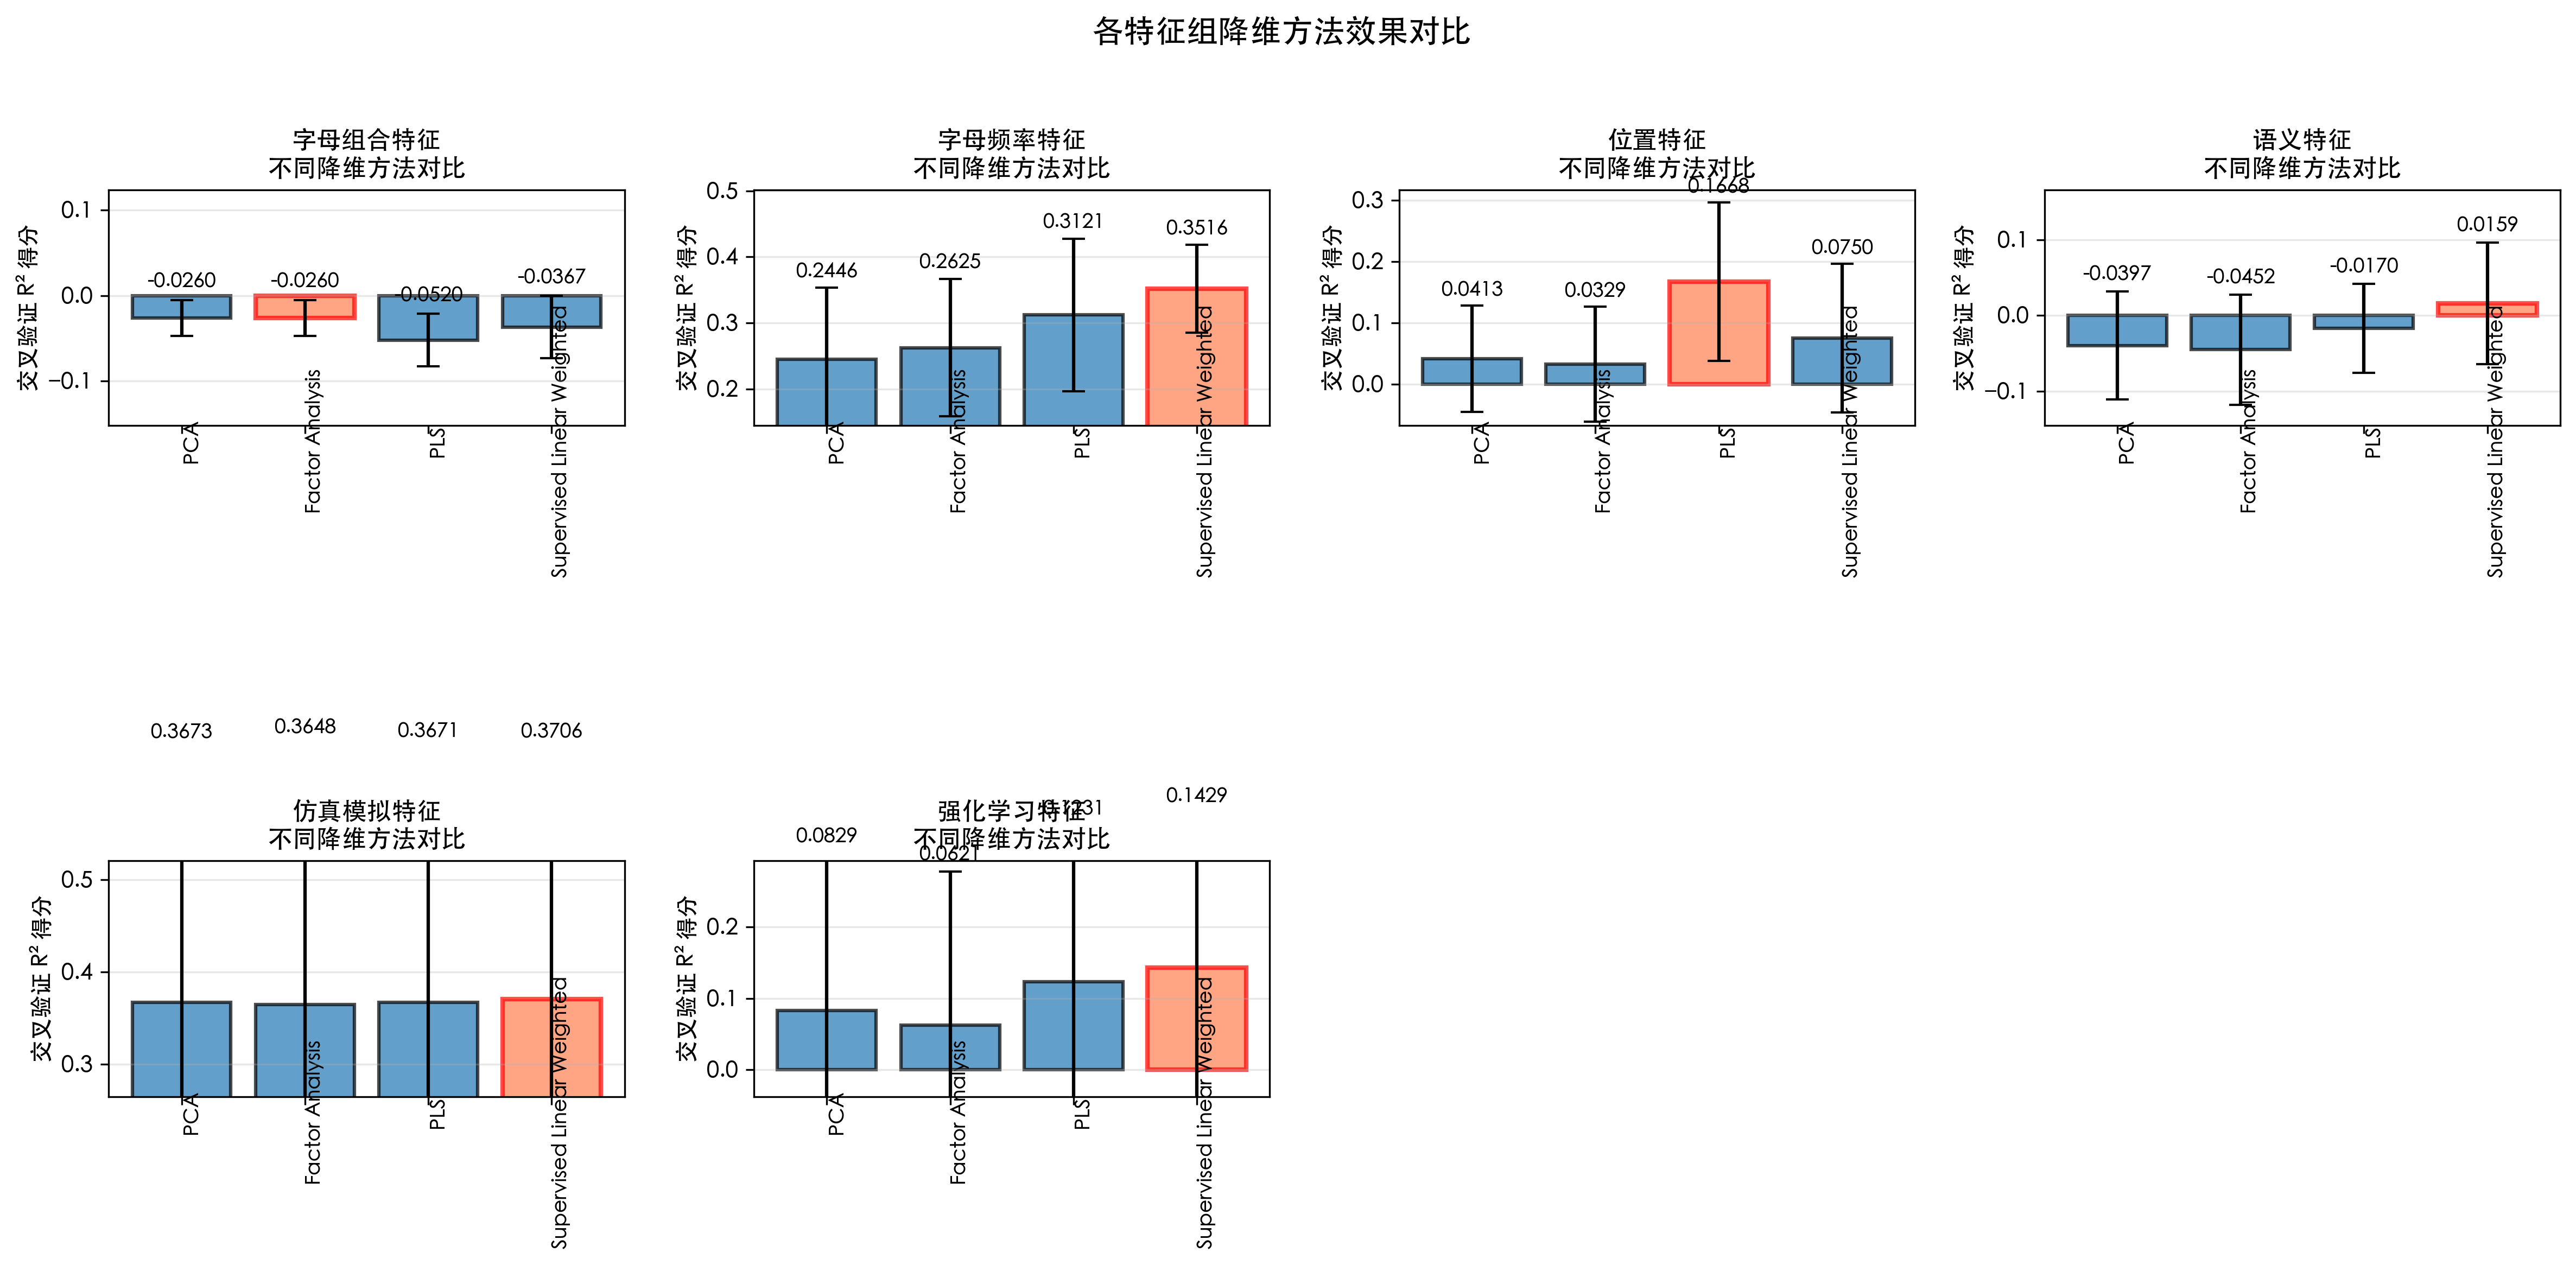


降维特征分布可视化


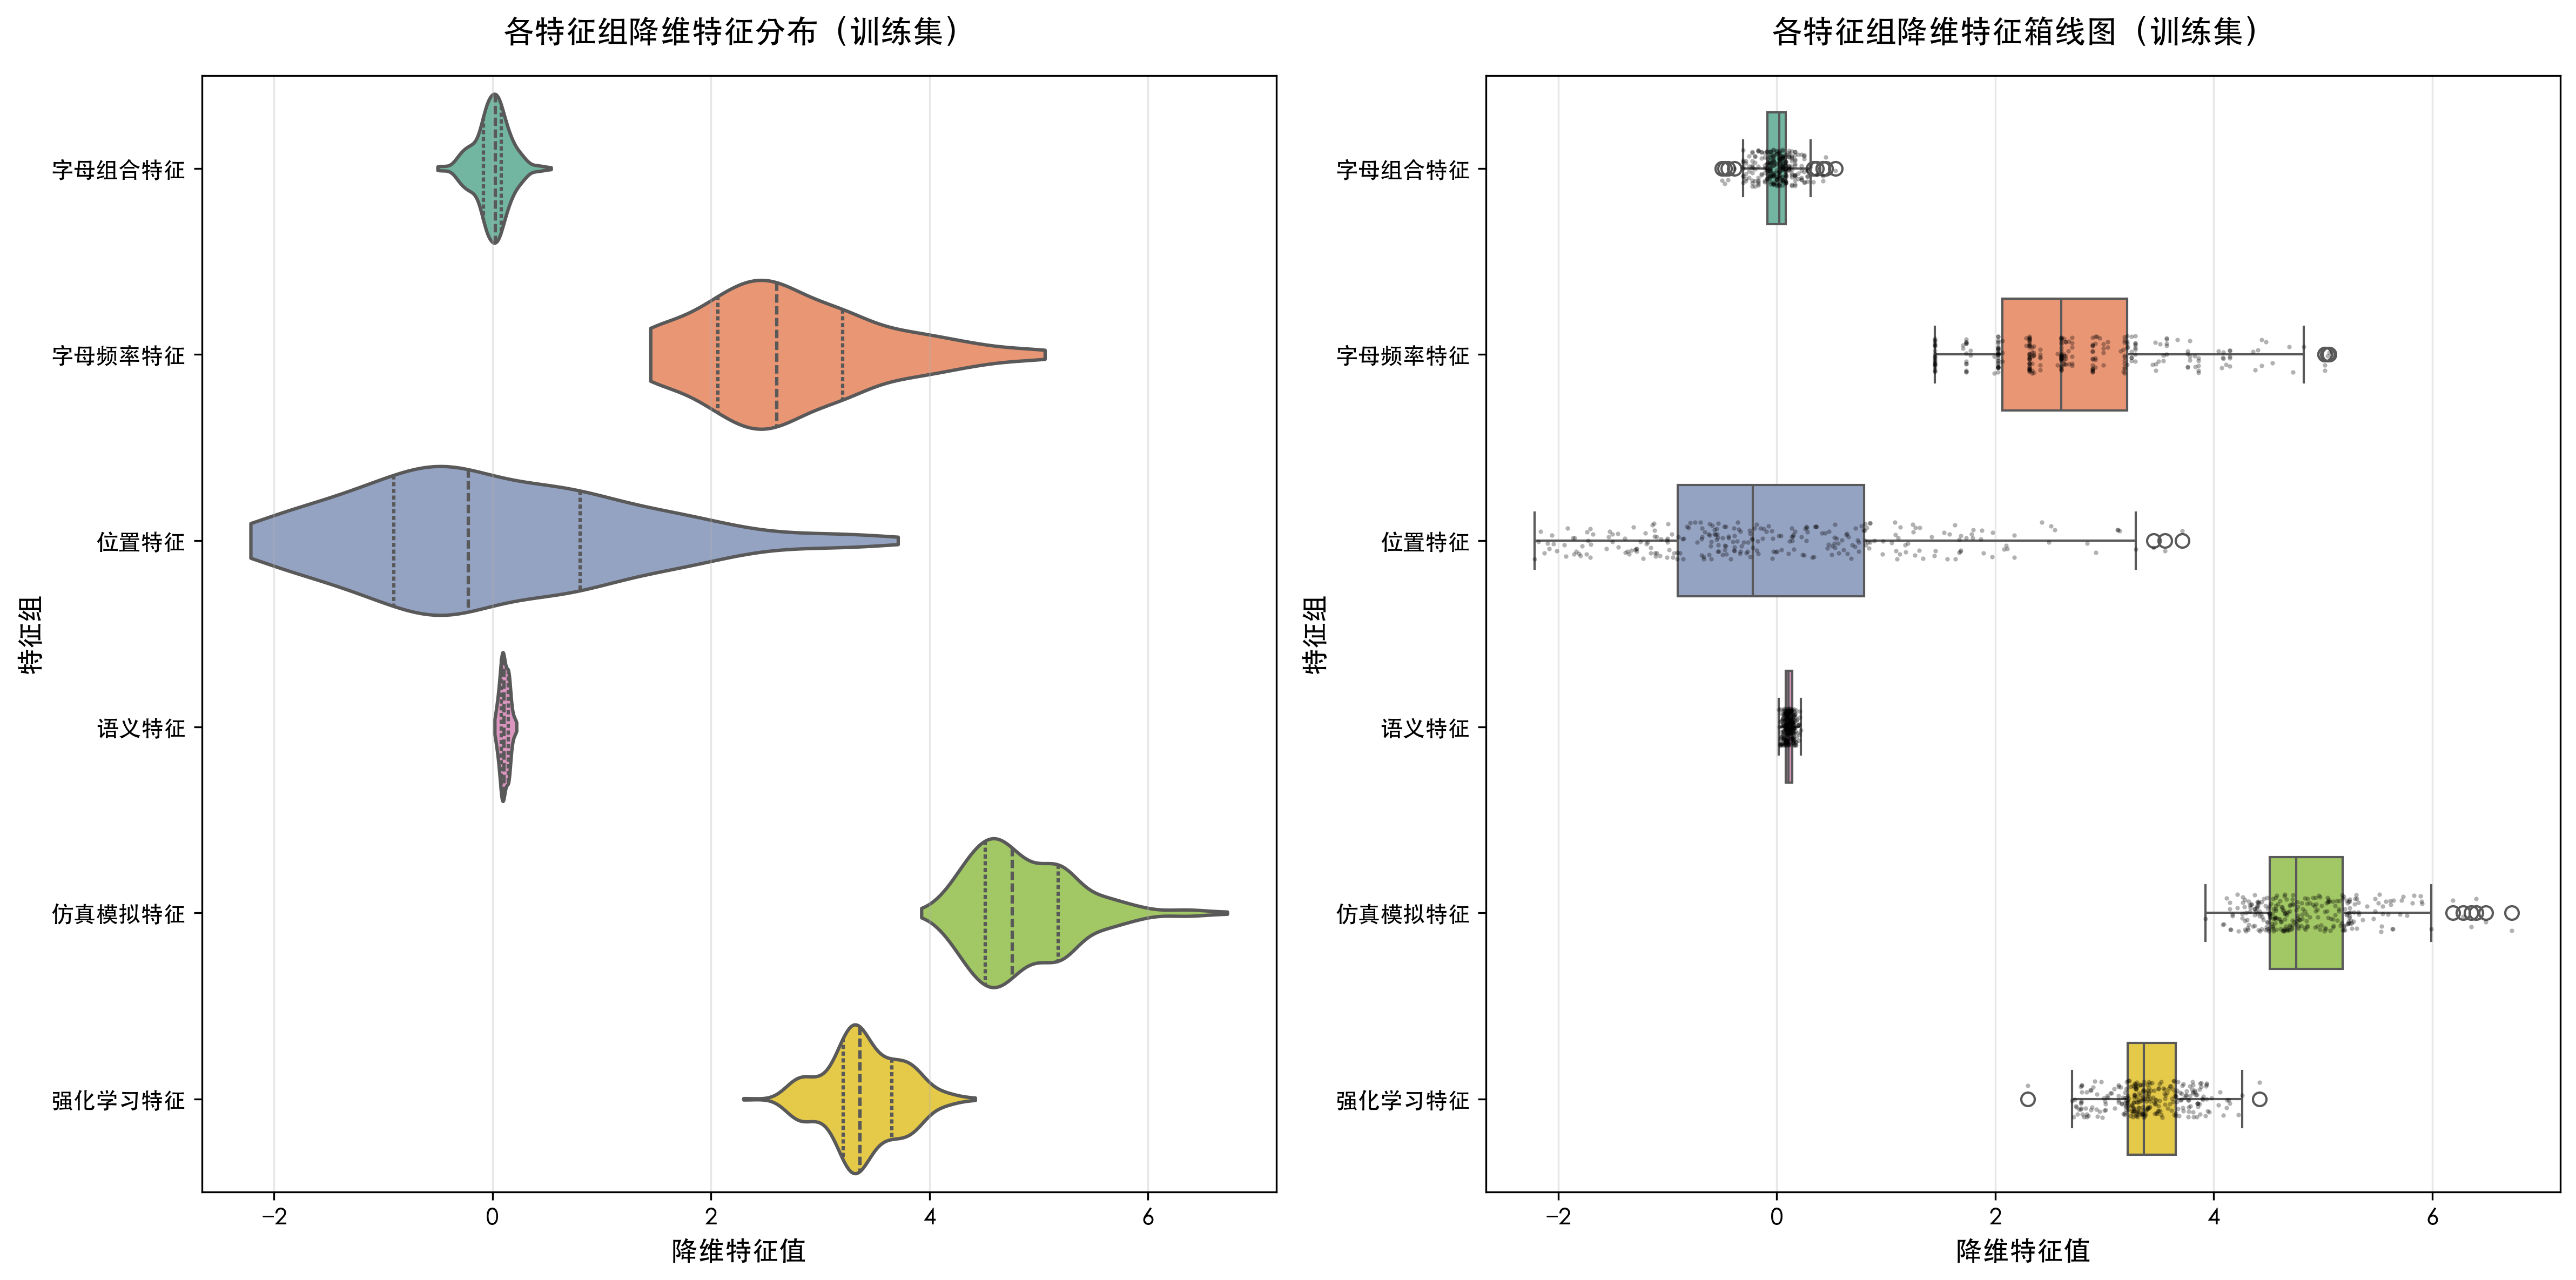


降维特征统计信息:

字母组合特征:
  均值: -0.000000
  标准差: 0.158002
  最小值: -0.502866
  最大值: 0.535299
  数据点数: 283

字母频率特征:
  均值: 2.715261
  标准差: 0.816286
  最小值: 1.445846
  最大值: 5.055601
  数据点数: 283

位置特征:
  均值: 0.000000
  标准差: 1.244687
  最小值: -2.214438
  最大值: 3.711021
  数据点数: 283

语义特征:
  均值: 0.109550
  标准差: 0.040872
  最小值: 0.019227
  最大值: 0.219222
  数据点数: 283

仿真模拟特征:
  均值: 4.856187
  标准差: 0.476256
  最小值: 3.925398
  最大值: 6.725410
  数据点数: 283

强化学习特征:
  均值: 3.399879
  标准差: 0.346042
  最小值: 2.296687
  最大值: 4.417758
  数据点数: 283


In [8]:
## 步骤3: 结果对比和可视化
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

# 创建对比表格
comparison_data = []
for group_name, group_data in all_reduction_results.items():
    results = group_data['results']
    for method_name, method_result in results.items():
        if method_result is not None:
            eval_result = method_result['evaluation']
            comparison_data.append({
                '特征组': group_name,
                '方法': method_name,
                'R²均值': eval_result['r2_mean'],
                'R²标准差': eval_result['r2_std'],
                'MSE均值': eval_result['mse_mean'],
                '特征数量': len(group_data['features'])
            })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n" + "="*80)
    print("降维方法效果对比汇总")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # 按特征组分组显示最优方法
    print("\n" + "="*80)
    print("各特征组最优降维方法")
    print("="*80)
    for group_name, group_data in all_reduction_results.items():
        if group_data['best_method']:
            best_result = group_data['results'][group_data['best_method']]
            eval_result = best_result['evaluation']
            print(f"\n{group_name}:")
            print(f"  最优方法: {group_data['best_method']}")
            print(f"  R²得分: {eval_result['r2_mean']:.6f} ± {eval_result['r2_std']:.6f}")
            print(f"  MSE: {eval_result['mse_mean']:.6f} ± {eval_result['mse_std']:.6f}")
    
    # 可视化对比（将所有组都进行可视化对比）
    n_groups = len(all_reduction_results)
    if n_groups > 0:
        # 计算需要多少行和列以容纳所有特征组，最多每行4列
        n_cols = 4
        n_rows = (n_groups + n_cols - 1) // n_cols
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows), dpi=300)
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        else:
            axes = axes.flatten()

        group_idx = 0
        for group_name, group_data in all_reduction_results.items():
            ax = axes[group_idx]
            results = group_data['results']

            # 准备数据
            methods = []
            r2_means = []
            r2_stds = []

            for method_name, method_result in results.items():
                if method_result is not None:
                    methods.append(method_name)
                    r2_means.append(method_result['evaluation']['r2_mean'])
                    r2_stds.append(method_result['evaluation']['r2_std'])

            if methods:
                bars = ax.bar(methods, r2_means, yerr=r2_stds, capsize=5,
                             alpha=0.7, edgecolor='black', linewidth=1.5)

                ax.set_xticks(range(len(methods)))
                ax.set_xticklabels(methods, rotation=90, ha='center', rotation_mode='anchor', fontsize=9)

                # 标记最优方法
                if group_data['best_method'] and group_data['best_method'] in methods:
                    best_idx = methods.index(group_data['best_method'])
                    bars[best_idx].set_color('coral')
                    bars[best_idx].set_edgecolor('red')
                    bars[best_idx].set_linewidth(2)

                # 添加数值标签
                for i, (bar, mean, std) in enumerate(zip(bars, r2_means, r2_stds)):
                    ax.text(bar.get_x() + bar.get_width()/2, mean + std + 0.01,
                            f'{mean:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

                ax.set_ylabel('交叉验证 R² 得分', fontsize=10)
                ax.set_title(f'{group_name}\n不同降维方法对比', fontsize=11, fontweight='bold')
                ax.grid(True, alpha=0.3, axis='y')
                if r2_means:
                    ax.set_ylim([min(r2_means) - 0.1, max(r2_means) + 0.15])
            else:
                ax.set_title(f'{group_name}\n无有效结果', fontsize=11, fontweight='bold')
                ax.axis('off')

            group_idx += 1

        # 隐藏多余的子图
        for idx in range(group_idx, len(axes)):
            axes[idx].axis('off')

        plt.suptitle('各特征组降维方法效果对比', fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()
        
    # 在这里可视化展示所有的降维特征
    print("\n" + "="*80)
    print("降维特征分布可视化")
    print("="*80)

    # 创建降维特征汇总表（提取训练集的降维特征用于可视化）
    reduced_feature_dfs = []
    for group_name, group_data in all_reduction_results.items():
        best_method = group_data['best_method']
        if best_method is None:
            continue
            
        method_result = group_data['results'].get(best_method)
        if method_result is None:
            continue
            
        features = group_data['features']
        train_idx = group_data['train_indices']
        
        # 确保train_idx是列表或数组
        if not isinstance(train_idx, (list, np.ndarray, pd.Index)):
            print(f"⚠️ 警告: {group_name} train_indices格式不正确，跳过")
            continue
        
        # 转换为列表以便后续使用
        train_idx = list(train_idx) if not isinstance(train_idx, list) else train_idx
        
        # 确保索引在X_train中存在
        valid_idx = [idx for idx in train_idx if idx in X_train.index]
        if len(valid_idx) == 0:
            print(f"⚠️ 警告: {group_name} 没有有效的训练集索引，跳过")
            continue
        train_idx = valid_idx
        
        # 确保只使用存在于X_train中的特征
        existing_features = [f for f in features if f in X_train.columns]
        if len(existing_features) == 0:
            print(f"⚠️ 警告: {group_name} 没有可用的特征，跳过")
            continue
        
        # 只考虑训练集
        try:
            # 准备数据
            X_group_train = X_train.loc[train_idx, existing_features].copy()
            # 填充缺失值
            median_values = X_train[existing_features].median()
            X_group_train = X_group_train.fillna(median_values)
            X_group_values = X_group_train.values
            
            if best_method == 'PCA':
                scaler = method_result.get('scaler')
                pca = method_result.get('pca')
                if scaler is None or pca is None:
                    continue
                X_train_scaled = scaler.transform(X_group_values)
                X_reduced = pca.transform(X_train_scaled)
                reduced_feat = X_reduced[:, 0] if X_reduced.ndim > 1 and X_reduced.shape[1] > 0 else X_reduced.flatten()
                
            elif best_method == 'Factor Analysis':
                scaler = method_result.get('scaler')
                fa = method_result.get('fa')
                if scaler is None or fa is None:
                    continue
                X_train_scaled = scaler.transform(X_group_values)
                X_reduced = fa.transform(X_train_scaled)
                reduced_feat = X_reduced[:, 0] if X_reduced.ndim > 1 and X_reduced.shape[1] > 0 else X_reduced.flatten()
                
            elif best_method == 'CCA':
                scaler = method_result.get('scaler')
                cca = method_result.get('cca')
                scaler_y = method_result.get('scaler_y')
                if scaler is None or cca is None or scaler_y is None:
                    continue
                X_train_scaled = scaler.transform(X_group_values)
                y_group_train = y_train.loc[train_idx].values
                y_train_scaled = scaler_y.transform(y_group_train.reshape(-1, 1))
                X_reduced, _ = cca.transform(X_train_scaled, y_train_scaled)
                reduced_feat = X_reduced[:, 0] if X_reduced.ndim > 1 and X_reduced.shape[1] > 0 else X_reduced.flatten()
                
            elif best_method == 'PLS':
                scaler = method_result.get('scaler')
                pls = method_result.get('pls')
                if scaler is None or pls is None:
                    continue
                X_train_scaled = scaler.transform(X_group_values)
                X_reduced = pls.transform(X_train_scaled)
                reduced_feat = X_reduced[:, 0] if X_reduced.ndim > 1 and X_reduced.shape[1] > 0 else X_reduced.flatten()
                            
            elif best_method == 'Supervised Linear Weighted':
                weights = method_result.get('weights')
                if weights is None:
                    weights = method_result.get('coef_')
                if weights is None:
                    continue
                
                # 确保weights是numpy数组并且是一维的
                weights = np.asarray(weights).flatten()
                
                # 确保权重长度与特征数量匹配
                if weights.shape[0] != len(existing_features):
                    if weights.shape[0] > len(existing_features):
                        weights = weights[:len(existing_features)]
                    else:
                        print(f"⚠️ 警告: {group_name} 权重数量({weights.shape[0]})与特征数量({len(existing_features)})不匹配，跳过")
                        continue
                
                # 计算降维特征
                reduced_feat = X_group_values @ weights
                
            else:
                # fallback: 尝试使用weights或coef_
                weights = method_result.get('weights')
                if weights is None:
                    weights = method_result.get('coef_')
                if weights is None:
                    continue
                
                # 确保weights是numpy数组并且是一维的
                weights = np.asarray(weights).flatten()
                
                if weights.shape[0] != len(existing_features):
                    if weights.shape[0] > len(existing_features):
                        weights = weights[:len(existing_features)]
                    else:
                        continue
                
                reduced_feat = X_group_values @ weights
            
            # 确保reduced_feat是一维numpy数组
            reduced_feat = np.asarray(reduced_feat).flatten()
            
            # 确保长度匹配
            if len(reduced_feat) != len(train_idx):
                print(f"⚠️ 警告: {group_name} 降维特征长度({len(reduced_feat)})与训练集索引长度({len(train_idx)})不匹配，跳过")
                continue
            
            # 创建DataFrame
            temp_df = pd.DataFrame({
                '降维特征值': reduced_feat,
                '特征组': group_name
            }, index=train_idx)
            reduced_feature_dfs.append(temp_df)
            
        except Exception as e:
            import traceback
            print(f"⚠️ 警告: {group_name} ({best_method}) 可视化失败: {str(e)}")
            print(f"   详细错误: {traceback.format_exc()[:200]}")
            continue

    if reduced_feature_dfs:
        reduced_features_all = pd.concat(reduced_feature_dfs).reset_index(drop=True)
        
        # 创建更美观的可视化
        fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=300)
        
        # 左图：Violin plot
        import seaborn as sns
        sns.violinplot(
            data=reduced_features_all, 
            y="特征组", x="降维特征值", 
            palette="Set2", cut=0, inner="quartile", scale='width', 
            linewidth=1.5, ax=axes[0]
        )
        axes[0].set_title("各特征组降维特征分布（训练集）", fontsize=14, fontweight='bold', pad=15)
        axes[0].set_xlabel("降维特征值", fontsize=12)
        axes[0].set_ylabel("特征组", fontsize=12)
        axes[0].grid(True, alpha=0.3, axis='x')
        
        # 右图：Box plot with swarm
        sns.boxplot(
            data=reduced_features_all,
            y="特征组", x="降维特征值",
            palette="Set2", ax=axes[1], width=0.6
        )
        sns.stripplot(
            data=reduced_features_all,
            y="特征组", x="降维特征值",
            color="black", alpha=0.3, size=2, ax=axes[1]
        )
        axes[1].set_title("各特征组降维特征箱线图（训练集）", fontsize=14, fontweight='bold', pad=15)
        axes[1].set_xlabel("降维特征值", fontsize=12)
        axes[1].set_ylabel("特征组", fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='x')
        
        plt.tight_layout()
        plt.savefig('pictures/reduced_features_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 打印统计信息
        print("\n降维特征统计信息:")
        print("="*80)
        for group_name in reduced_features_all['特征组'].unique():
            group_data = reduced_features_all[reduced_features_all['特征组'] == group_name]['降维特征值']
            print(f"\n{group_name}:")
            print(f"  均值: {group_data.mean():.6f}")
            print(f"  标准差: {group_data.std():.6f}")
            print(f"  最小值: {group_data.min():.6f}")
            print(f"  最大值: {group_data.max():.6f}")
            print(f"  数据点数: {len(group_data)}")
    else:
        print("⚠️ 没有成功生成降维特征用于可视化")

else:
    print("⚠️ 没有可对比的结果")


In [9]:
## 步骤4: 应用最优降维方法，分别创建训练集和测试集的降维特征

print("="*80)
print("应用最优降维方法，分别创建训练集和测试集的降维特征...")
print("="*80)

# 存储可解释性信息
interpretability_report = {}

# 初始化训练集和测试集的降维特征字典
train_reduced_features = {}
test_reduced_features = {}

# 为每个特征组创建最优降维特征（分别处理训练集和测试集）
for group_name, group_data in all_reduction_results.items():
    features = group_data['features']
    best_method = group_data['best_method']
    train_indices = group_data['train_indices']
    test_indices = group_data['test_indices']
    results = group_data['results']
    
    if not best_method or best_method not in results:
        continue
    
    print(f"\n{group_name}:")
    print(f"  最优方法: {best_method}")
    
    # 准备训练集和测试集数据
    X_group_train = X_train[features].copy()
    X_group_test = X_test[features].copy()
    
    # 根据最优方法创建降维特征
    method_result = results[best_method]
    interpret_info = method_result.get('interpretability', {})
    
    # 获取训练集和测试集的降维结果
    if best_method == 'PCA':
        # 训练集：使用训练好的模型transform
        scaler = method_result['scaler']
        pca = method_result['pca']
        X_train_scaled = scaler.transform(X_group_train.values)
        X_train_reduced = pca.transform(X_train_scaled)
        reduced_feature_train = X_train_reduced[:, 0]
        
        # 测试集：使用训练好的模型transform（已在降维循环中完成）
        reduced_feature_test = method_result['X_test_reduced'][:, 0] if method_result['X_test_reduced'].ndim > 1 else method_result['X_test_reduced']
        
        feature_name = f'{group_name}_PCA_reduced'
        
        # 可解释性：显示主成分载荷
        components = pca.components_[0]  # 第一主成分
        explained_var = pca.explained_variance_ratio_[0]
        print(f"  使用PCA-1，解释方差: {explained_var:.4f}")
        print(f"  主成分载荷（前5个最重要的特征）:")
        loadings_dict = dict(zip(features, components))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        for feat, loading in sorted_loadings[:5]:
            print(f"    {feat}: {loading:.4f}")
        
        interpretability_report[group_name] = {
            'method': 'PCA',
            'explained_variance': explained_var,
            'component_loadings': loadings_dict,
            'top_features': sorted_loadings[:5]
        }
        
    elif best_method == 'Factor Analysis':
        # 训练集
        scaler = method_result['scaler']
        fa = method_result['fa']
        X_train_scaled = scaler.transform(X_group_train.values)
        X_train_reduced = fa.transform(X_train_scaled)
        reduced_feature_train = X_train_reduced[:, 0] if X_train_reduced.ndim > 1 else X_train_reduced
        
        # 测试集
        reduced_feature_test = method_result['X_test_reduced'][:, 0] if method_result['X_test_reduced'].ndim > 1 else method_result['X_test_reduced']
        
        feature_name = f'{group_name}_FA_reduced'
        
        # 可解释性：显示因子载荷
        components = fa.components_[0] if fa.components_.ndim > 1 else fa.components_
        print(f"  因子载荷（前5个最重要的特征）:")
        loadings_dict = dict(zip(features, components))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        for feat, loading in sorted_loadings[:5]:
            print(f"    {feat}: {loading:.4f}")
        
        interpretability_report[group_name] = {
            'method': 'Factor Analysis',
            'factor_loadings': loadings_dict,
            'top_features': sorted_loadings[:5]
        }
        
    elif best_method == 'CCA':
        # 训练集
        scaler = method_result['scaler']
        scaler_y = method_result['scaler_y']
        cca = method_result['cca']
        X_train_scaled = scaler.transform(X_group_train.values)
        y_train_scaled = scaler_y.transform(y_train[train_indices].values.reshape(-1, 1))
        X_train_reduced, _ = cca.transform(X_train_scaled, y_train_scaled)
        reduced_feature_train = X_train_reduced[:, 0] if X_train_reduced.ndim > 1 else X_train_reduced
        
        # 测试集
        reduced_feature_test = method_result['X_test_reduced'][:, 0] if method_result['X_test_reduced'].ndim > 1 else method_result['X_test_reduced']
        
        feature_name = f'{group_name}_CCA_reduced'
        
        # 可解释性
        canonical_corrs = method_result['canonical_correlations']
        corr = canonical_corrs[0] if isinstance(canonical_corrs, (list, np.ndarray)) and len(canonical_corrs) > 0 else (canonical_corrs if not isinstance(canonical_corrs, (list, np.ndarray)) else 0)
        x_loadings = cca.x_loadings_[:, 0] if cca.x_loadings_.ndim > 1 else cca.x_loadings_
        loadings_dict = dict(zip(features, x_loadings))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        print(f"  典型相关系数: {corr:.4f}")
        print(f"  CCA载荷（前5个最重要的特征）:")
        for feat, loading in sorted_loadings[:5]:
            print(f"    {feat}: {loading:.4f}")
        
        interpretability_report[group_name] = {
            'method': 'CCA',
            'canonical_correlation': corr,
            'x_loadings': loadings_dict,
            'top_features': sorted_loadings[:5]
        }
        
    elif best_method == 'PLS':
        # 训练集
        scaler = method_result['scaler']
        pls = method_result['pls']
        X_train_scaled = scaler.transform(X_group_train.values)
        X_train_reduced = pls.transform(X_train_scaled)
        reduced_feature_train = X_train_reduced[:, 0] if X_train_reduced.ndim > 1 else X_train_reduced
        
        # 测试集
        reduced_feature_test = method_result['X_test_reduced'][:, 0] if method_result['X_test_reduced'].ndim > 1 else method_result['X_test_reduced']
        
        feature_name = f'{group_name}_PLS_reduced'
        
        # 可解释性
        x_loadings = pls.x_loadings_[:, 0] if pls.x_loadings_.ndim > 1 else pls.x_loadings_
        loadings_dict = dict(zip(features, x_loadings))
        sorted_loadings = sorted(loadings_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        print(f"  PLS载荷（前5个最重要的特征）:")
        for feat, loading in sorted_loadings[:5]:
            print(f"    {feat}: {loading:.4f}")
        
        interpretability_report[group_name] = {
            'method': 'PLS',
            'x_loadings': loadings_dict,
            'top_features': sorted_loadings[:5]
        }
        
    elif best_method == 'Supervised Linear Weighted':
        # 训练集
        scaler = method_result['scaler']
        weights = method_result['weights']
        X_train_scaled = scaler.transform(X_group_train.values)
        reduced_feature_train = X_train_scaled @ weights
        
        # 测试集
        reduced_feature_test = method_result['X_test_reduced']
        
        feature_name = f'{group_name}_weighted_reduced'
        
        # 可解释性
        weight_dict = method_result['interpretability']['weight_dict']
        sorted_weights = sorted(weight_dict.items(), key=lambda x: abs(x[1]), reverse=True)
        print(f"  线性加权权重（前5个最重要的特征）:")
        for feat, w in sorted_weights[:5]:
            print(f"    {feat}: {w:.4f}")
        
        interpretability_report[group_name] = {
            'method': 'Supervised Linear Weighted',
            'weights': weight_dict,
            'top_features': sorted_weights[:5]
        }
    
    # 保存训练集和测试集的降维特征
    train_reduced_features[feature_name] = pd.Series(reduced_feature_train, index=train_indices)
    test_reduced_features[feature_name] = pd.Series(reduced_feature_test, index=test_indices)
    
    eval_result = method_result['evaluation']
    print(f"  ✅ 已创建特征列: {feature_name}")
    print(f"  训练集R²: {method_result['evaluation_train']['r2_mean']:.6f} ± {method_result['evaluation_train']['r2_std']:.6f}")
    print(f"  测试集R²: {eval_result['r2_mean']:.6f} ± {eval_result['r2_std']:.6f}")

print(f"\n{'='*80}")
print("降维特征创建完成！")
print(f"{'='*80}")

# 显示新创建的特征列
new_features = list(train_reduced_features.keys())
print(f"\n新创建的降维特征列 ({len(new_features)} 个):")
for feat in new_features:
    print(f"  - {feat}")

# 创建训练集和测试集的DataFrame（包含降维特征）
train_reduced_df = pd.DataFrame(train_reduced_features)
test_reduced_df = pd.DataFrame(test_reduced_features)

print(f"\n训练集降维特征形状: {train_reduced_df.shape}")
print(f"测试集降维特征形状: {test_reduced_df.shape}")

# 显示新特征的统计信息
if len(new_features) > 0:
    print(f"\n训练集降维特征统计信息:")
    print(train_reduced_df.describe())
    print(f"\n测试集降维特征统计信息:")
    print(test_reduced_df.describe())

## 步骤4.5: 保存降维模型

import pickle
import os

# 创建模型保存目录
os.makedirs('models/reduction_models', exist_ok=True)

# 准备保存的模型信息
reduction_models_to_save = {}

for group_name, model_info in all_reduction_models.items():
    features = model_info['features']
    method = model_info['method']
    model_result = model_info['model_result']
    
    # 获取训练时的中位数（用于缺失值填充）
    X_train_group = X_train[features].copy()
    median_values = X_train_group.median().to_dict()
    
    reduction_models_to_save[group_name] = {
        'features': features,
        'method': method,
        'scaler': model_result.get('scaler'),
        'median_values': median_values,
        'feature_name': f'{group_name}_{method}_reduced' if method == 'PCA' else (
            f'{group_name}_FA_reduced' if method == 'Factor Analysis' else (
            f'{group_name}_CCA_reduced' if method == 'CCA' else (
            f'{group_name}_PLS_reduced' if method == 'PLS' else
            f'{group_name}_weighted_reduced'
        )))
    }
    
    # 根据方法保存相应的模型对象
    if method == 'PCA':
        reduction_models_to_save[group_name]['pca'] = model_result.get('pca')
        reduction_models_to_save[group_name]['n_components'] = model_result.get('n_components', 1)
    elif method == 'Factor Analysis':
        reduction_models_to_save[group_name]['fa'] = model_result.get('fa')
        reduction_models_to_save[group_name]['n_components'] = model_result.get('n_components', 1)
    elif method == 'CCA':
        reduction_models_to_save[group_name]['cca'] = model_result.get('cca')
        reduction_models_to_save[group_name]['scaler_y'] = model_result.get('scaler_y')
        reduction_models_to_save[group_name]['n_components'] = model_result.get('n_components', 1)
    elif method == 'PLS':
        reduction_models_to_save[group_name]['pls'] = model_result.get('pls')
        reduction_models_to_save[group_name]['n_components'] = model_result.get('n_components', 1)
    elif method == 'Supervised Linear Weighted':
        reduction_models_to_save[group_name]['weights'] = model_result.get('weights')

# 保存单特征组的信息（不需要降维的特征）
non_reduced_info = {}
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        feat = existing_features[0]
        non_reduced_info[group_name] = {
            'feature': feat,
            'feature_name': feat
        }

# 保存所有模型
models_save_path = 'models/reduction_models/reduction_models.pkl'
with open(models_save_path, 'wb') as f:
    pickle.dump({
        'reduction_models': reduction_models_to_save,
        'non_reduced_features': non_reduced_info,
        'feature_categories': feature_categories,
        'train_test_split_info': {
            'train_size': len(X_train),
            'test_size': len(X_test),
            'random_state': 42,
            'train_indices': X_train.index.tolist(),
            'test_indices': X_test.index.tolist()
        }
    }, f)

print(f"\n{'='*80}")
print("降维模型保存完成！")
print(f"{'='*80}")
print(f"✅ 已保存 {len(reduction_models_to_save)} 个降维模型到: {models_save_path}")
print(f"✅ 已保存 {len(non_reduced_info)} 个不需要降维的特征信息")
print(f"✅ 已保存训练集/测试集划分信息")


应用最优降维方法，分别创建训练集和测试集的降维特征...

字母组合特征:
  最优方法: Factor Analysis
  因子载荷（前5个最重要的特征）:
    letter_entropy: 0.1125
    hamming_neighbors: 0.1125
  ✅ 已创建特征列: 字母组合特征_FA_reduced
  训练集R²: 0.018811 ± 0.116830
  测试集R²: -0.026019 ± 0.021008

字母频率特征:
  最优方法: Supervised Linear Weighted
  线性加权权重（前5个最重要的特征）:
    has_double_letter: 0.3293
    scrabble_score: 0.2892
    has_common_suffix: 0.2582
    num_rare_letters: 0.0996
    contains_y: 0.0238
  ✅ 已创建特征列: 字母频率特征_weighted_reduced
  训练集R²: 0.219414 ± 0.107386
  测试集R²: 0.351588 ± 0.066257

位置特征:
  最优方法: PLS
  PLS载荷（前5个最重要的特征）:
    positional_freq_min: 0.7469
    positional_freq_mean: 0.6554
    positional_fit: 0.4918
    position_self_entropy_2_letters: -0.4270
  ✅ 已创建特征列: 位置特征_PLS_reduced
  训练集R²: 0.103466 ± 0.045702
  测试集R²: 0.166831 ± 0.129015

语义特征:
  最优方法: Supervised Linear Weighted
  线性加权权重（前5个最重要的特征）:
    semantic_distance: 0.7017
    semantic_density: 0.2983
    semantic_neighbors_count: 0.0000
  ✅ 已创建特征列: 语义特征_weighted_reduced
  训练集R²: 0.047893 ±


特征降维可解释性报告

【字母组合特征】
降维方法: Factor Analysis
因子载荷（前5个最重要的原始特征）:
  1. letter_entropy: 0.1125 (载荷)
     解释: 该特征在潜在因子中的载荷为 0.1125
  2. hamming_neighbors: 0.1125 (载荷)
     解释: 该特征在潜在因子中的载荷为 0.1125

【字母频率特征】
降维方法: Supervised Linear Weighted
线性加权权重（前5个最重要的原始特征）:
  1. has_double_letter: 0.3293 (权重, 占比 32.9%)
     解释: 该特征在组合特征中的权重为 0.3293，相对重要性为 32.9%
  2. scrabble_score: 0.2892 (权重, 占比 28.9%)
     解释: 该特征在组合特征中的权重为 0.2892，相对重要性为 28.9%
  3. has_common_suffix: 0.2582 (权重, 占比 25.8%)
     解释: 该特征在组合特征中的权重为 0.2582，相对重要性为 25.8%
  4. num_rare_letters: 0.0996 (权重, 占比 10.0%)
     解释: 该特征在组合特征中的权重为 0.0996，相对重要性为 10.0%
  5. contains_y: 0.0238 (权重, 占比 2.4%)
     解释: 该特征在组合特征中的权重为 0.0238，相对重要性为 2.4%

【位置特征】
降维方法: PLS
PLS载荷（前5个最重要的原始特征）:
  1. positional_freq_min: 0.7469 (载荷)
     解释: 该特征在预测目标变量时的贡献度为 0.7469
  2. positional_freq_mean: 0.6554 (载荷)
     解释: 该特征在预测目标变量时的贡献度为 0.6554
  3. positional_fit: 0.4918 (载荷)
     解释: 该特征在预测目标变量时的贡献度为 0.4918
  4. position_self_entropy_2_letters: -0.4270 (载荷)
     解释: 该特征在预

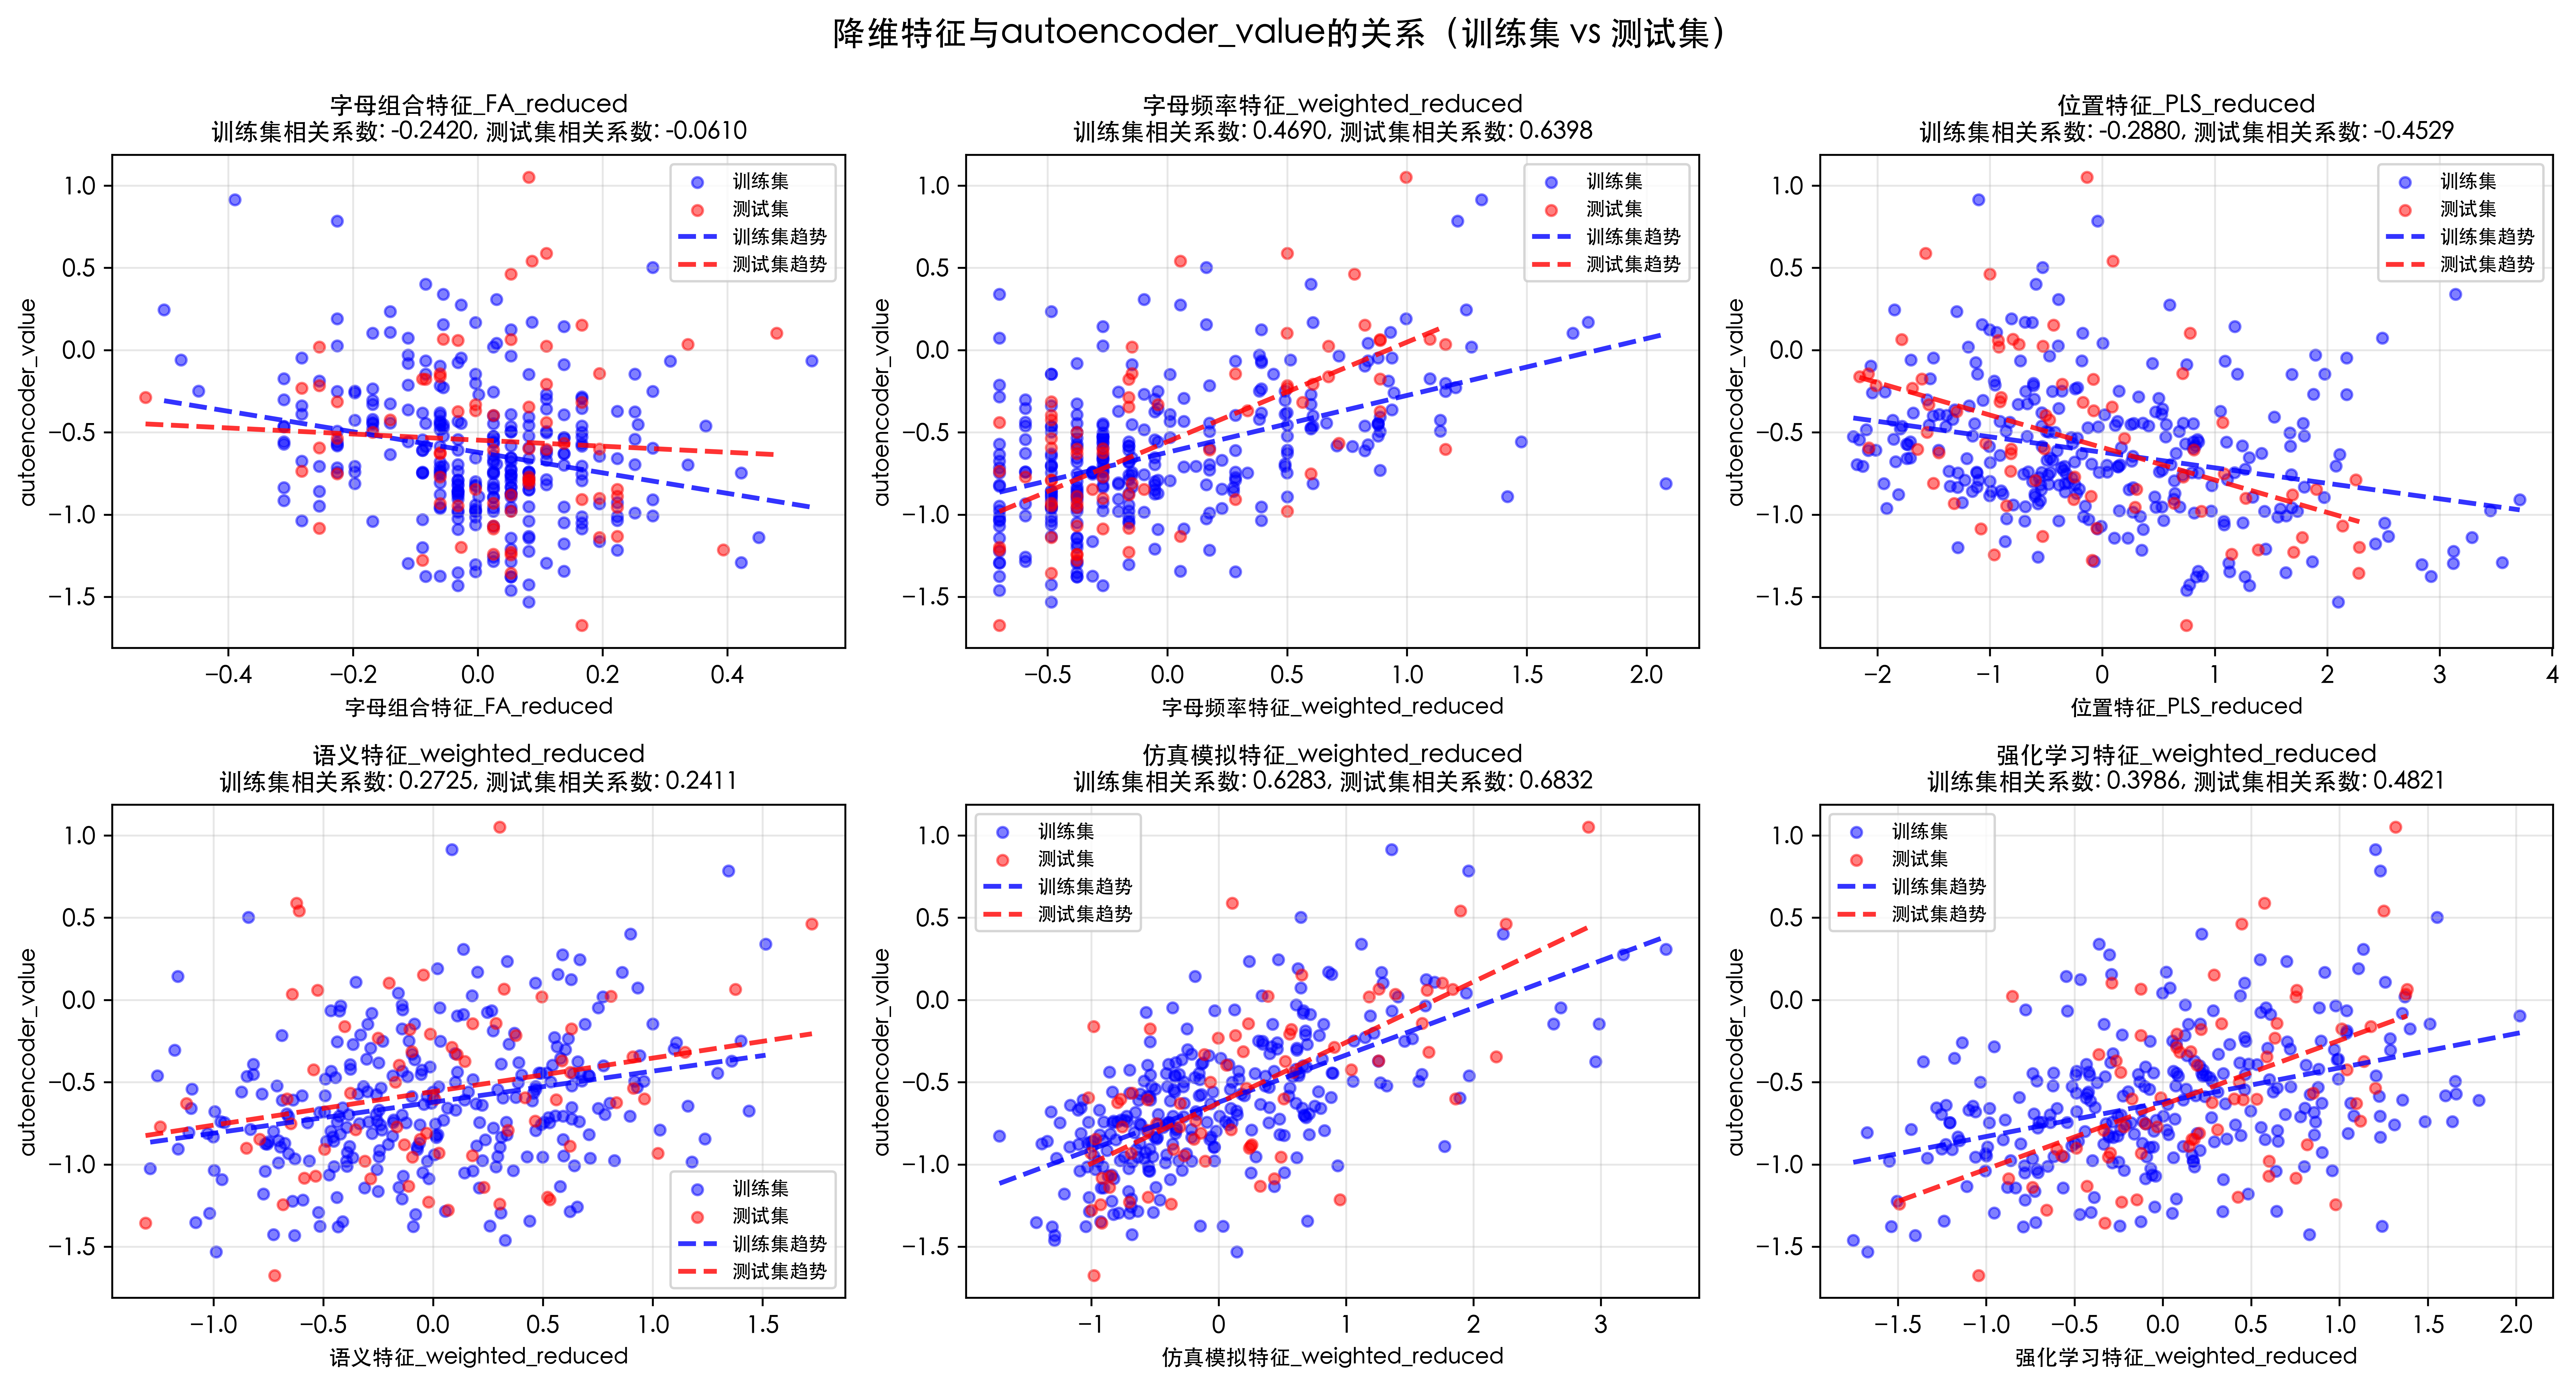


✓ 使用特征: 保留原始特征 'Zipf-value'（单特征，无需降维）

✓ 反馈特征: 保留原始特征 'feedback_entropy'（单特征，无需降维）

✓ 键盘距离特征: 保留原始特征 'keyboard_distance'（单特征，无需降维）

降维分析总结
✓ 已对 6 个特征组进行了降维分析
✓ 使用了 5 种降维方法: PCA, Factor Analysis, CCA, PLS, Supervised Linear Weighted
✓ 所有方法都在训练集上训练，在测试集上评估，避免数据泄露
✓ 创建了 6 个降维特征列
✓ 保留了 3 个不需要降维的原始特征
✓ 所有降维方法都保留了可解释性信息（载荷、权重等）

降维特征列表（训练集/测试集相关系数）:
  - 字母组合特征_FA_reduced
    训练集相关系数: -0.2420, 测试集相关系数: -0.0610
  - 字母频率特征_weighted_reduced
    训练集相关系数: 0.4690, 测试集相关系数: 0.6398
  - 位置特征_PLS_reduced
    训练集相关系数: -0.2880, 测试集相关系数: -0.4529
  - 语义特征_weighted_reduced
    训练集相关系数: 0.2725, 测试集相关系数: 0.2411
  - 仿真模拟特征_weighted_reduced
    训练集相关系数: 0.6283, 测试集相关系数: 0.6832
  - 强化学习特征_weighted_reduced
    训练集相关系数: 0.3986, 测试集相关系数: 0.4821

不需要降维的原始特征列表（训练集/测试集相关系数）:
  - Zipf-value
    训练集相关系数: -0.2099, 测试集相关系数: -0.2533
  - feedback_entropy
    训练集相关系数: -0.5227, 测试集相关系数: -0.4614
  - keyboard_distance
    训练集相关系数: -0.1184, 测试集相关系数: -0.1396


In [10]:
## 步骤5: 可解释性分析和最终总结
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体
# 生成可解释性报告
print("\n" + "="*80)
print("特征降维可解释性报告")
print("="*80)

for group_name, interpret_info in interpretability_report.items():
    print(f"\n【{group_name}】")
    print(f"降维方法: {interpret_info['method']}")
    
    if interpret_info['method'] == 'PCA':
        print(f"解释方差: {interpret_info['explained_variance']:.4f}")
        print("主成分构成（前5个最重要的原始特征）:")
        for i, (feat, loading) in enumerate(interpret_info['top_features'], 1):
            print(f"  {i}. {feat}: {loading:.4f} (载荷)")
            print(f"     解释: 该特征在主成分中的贡献度为 {abs(loading):.4f}")
    
    elif interpret_info['method'] == 'Factor Analysis':
        print("因子载荷（前5个最重要的原始特征）:")
        for i, (feat, loading) in enumerate(interpret_info['top_features'], 1):
            print(f"  {i}. {feat}: {loading:.4f} (载荷)")
            print(f"     解释: 该特征在潜在因子中的载荷为 {abs(loading):.4f}")
    
    elif interpret_info['method'] == 'CCA':
        canonical_corrs = interpret_info.get('canonical_correlation', interpret_info.get('canonical_correlations', [0]))
        if isinstance(canonical_corrs, (list, np.ndarray)) and len(canonical_corrs) > 0:
            corr = canonical_corrs[0]
        else:
            corr = canonical_corrs if not isinstance(canonical_corrs, (list, np.ndarray)) else 0
        print(f"典型相关系数: {corr:.4f}")
        print("CCA载荷（前5个最重要的原始特征）:")
        for i, (feat, loading) in enumerate(interpret_info['top_features'], 1):
            print(f"  {i}. {feat}: {loading:.4f} (载荷)")
            print(f"     解释: 该特征与目标变量的典型相关贡献度为 {abs(loading):.4f}")
    
    elif interpret_info['method'] == 'PLS':
        print("PLS载荷（前5个最重要的原始特征）:")
        for i, (feat, loading) in enumerate(interpret_info['top_features'], 1):
            print(f"  {i}. {feat}: {loading:.4f} (载荷)")
            print(f"     解释: 该特征在预测目标变量时的贡献度为 {abs(loading):.4f}")
    
    elif interpret_info['method'] == 'Supervised Linear Weighted':
        print("线性加权权重（前5个最重要的原始特征）:")
        total_weight = sum(abs(w) for w in interpret_info['weights'].values())
        for i, (feat, weight) in enumerate(interpret_info['top_features'], 1):
            weight_pct = (abs(weight) / total_weight * 100) if total_weight > 0 else 0
            print(f"  {i}. {feat}: {weight:.4f} (权重, 占比 {weight_pct:.1f}%)")
            print(f"     解释: 该特征在组合特征中的权重为 {weight:.4f}，相对重要性为 {weight_pct:.1f}%")

# 可视化降维特征与目标变量的关系（分别显示训练集和测试集）
# 注意：new_features已经在步骤4中定义
if len(new_features) > 0:
    n_new_features = len(new_features)
    n_cols = min(3, n_new_features)
    n_rows = (n_new_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows), dpi=600)
    if n_new_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()
    
    for idx, feat in enumerate(new_features):
        ax = axes[idx] if n_new_features > 1 else axes[0]
        
        # 训练集散点图
        train_feat_values = train_reduced_df[feat].values
        train_target_values = y_train.values
        ax.scatter(train_feat_values, train_target_values, 
                  alpha=0.5, s=20, label='训练集', color='blue')
        
        # 测试集散点图
        test_feat_values = test_reduced_df[feat].values
        test_target_values = y_test.values
        ax.scatter(test_feat_values, test_target_values, 
                  alpha=0.5, s=20, label='测试集', color='red')
        
        # 训练集趋势线
        if len(train_feat_values) > 1:
            z_train = np.polyfit(train_feat_values, train_target_values, 1)
            p_train = np.poly1d(z_train)
            x_trend_train = np.linspace(train_feat_values.min(), train_feat_values.max(), 100)
            ax.plot(x_trend_train, p_train(x_trend_train), "b--", alpha=0.8, linewidth=2, label='训练集趋势')
        
        # 测试集趋势线
        if len(test_feat_values) > 1:
            z_test = np.polyfit(test_feat_values, test_target_values, 1)
            p_test = np.poly1d(z_test)
            x_trend_test = np.linspace(test_feat_values.min(), test_feat_values.max(), 100)
            ax.plot(x_trend_test, p_test(x_trend_test), "r--", alpha=0.8, linewidth=2, label='测试集趋势')
        
        # 计算相关系数
        corr_train = np.corrcoef(train_feat_values, train_target_values)[0, 1]
        corr_test = np.corrcoef(test_feat_values, test_target_values)[0, 1]
        
        ax.set_xlabel(f'{feat}', fontsize=9)
        ax.set_ylabel(target_feature, fontsize=9)
        ax.set_title(f'{feat}\n训练集相关系数: {corr_train:.4f}, 测试集相关系数: {corr_test:.4f}', fontsize=10)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # 隐藏多余的子图
    for idx in range(n_new_features, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle('降维特征与autoencoder_value的关系（训练集 vs 测试集）', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# 收集不需要降维的特征（单特征组）
# 这些特征组只有1个特征，所以直接保留，不需要降维
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)
            print(f"\n✓ {group_name}: 保留原始特征 '{feat}'（单特征，无需降维）")

# 最终总结
print("\n" + "="*80)
print("降维分析总结")
print("="*80)
print(f"✓ 已对 {len(all_reduction_results)} 个特征组进行了降维分析")
print(f"✓ 使用了 5 种降维方法: PCA, Factor Analysis, CCA, PLS, Supervised Linear Weighted")
print(f"✓ 所有方法都在训练集上训练，在测试集上评估，避免数据泄露")
print(f"✓ 创建了 {len(new_features)} 个降维特征列")
print(f"✓ 保留了 {len(non_reduced_features)} 个不需要降维的原始特征")
print(f"✓ 所有降维方法都保留了可解释性信息（载荷、权重等）")
print(f"\n降维特征列表（训练集/测试集相关系数）:")
for feat in new_features:
    # 计算训练集和测试集的相关系数
    train_feat_values = train_reduced_df[feat].values
    train_target_values = y_train.values
    test_feat_values = test_reduced_df[feat].values
    test_target_values = y_test.values
    
    corr_train = np.corrcoef(train_feat_values, train_target_values)[0, 1] if len(train_feat_values) > 1 else 0
    corr_test = np.corrcoef(test_feat_values, test_target_values)[0, 1] if len(test_feat_values) > 1 else 0
    print(f"  - {feat}")
    print(f"    训练集相关系数: {corr_train:.4f}, 测试集相关系数: {corr_test:.4f}")
print(f"\n不需要降维的原始特征列表（训练集/测试集相关系数）:")
for feat in non_reduced_features:
    # 计算训练集和测试集的相关系数
    train_feat_values = train_df[feat].values
    train_target_values = y_train.values
    test_feat_values = test_df[feat].values
    test_target_values = y_test.values
    
    corr_train = np.corrcoef(train_feat_values, train_target_values)[0, 1] if len(train_feat_values) > 1 else 0
    corr_test = np.corrcoef(test_feat_values, test_target_values)[0, 1] if len(test_feat_values) > 1 else 0
    print(f"  - {feat}")
    print(f"    训练集相关系数: {corr_train:.4f}, 测试集相关系数: {corr_test:.4f}")
print("="*80)


In [11]:
## 步骤6: 分别保存训练集和测试集的降维特征到CSV文件

# 收集不需要降维的特征（单特征组）
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)

# 合并所有特征（降维特征 + 不需要降维的原始特征）
all_features_for_prediction = new_features + non_reduced_features

if len(all_features_for_prediction) > 0:
    # 准备训练集数据
    train_all_features = train_reduced_df.copy()
    # 添加不需要降维的原始特征
    for feat in non_reduced_features:
        train_all_features[feat] = train_df[feat].values
    
    # 添加目标变量和word列（如果存在）
    if 'word' in train_df.columns:
        train_all_features['word'] = train_df['word'].values
    train_all_features[target_feature] = y_train.values
    
    # 准备测试集数据
    test_all_features = test_reduced_df.copy()
    # 添加不需要降维的原始特征
    for feat in non_reduced_features:
        test_all_features[feat] = test_df[feat].values
    
    # 添加目标变量和word列（如果存在）
    if 'word' in test_df.columns:
        test_all_features['word'] = test_df['word'].values
    test_all_features[target_feature] = y_test.values
    
    # 保存训练集
    train_output_file = 'data/reduced_features_train.csv'
    train_all_features.to_csv(train_output_file, index=False)
    print(f"\n{'='*80}")
    print("训练集降维特征保存完成！")
    print(f"{'='*80}")
    print(f"✅ 训练集已保存到: {train_output_file}")
    print(f"   包含 {len(new_features)} 个降维特征")
    print(f"   包含 {len(non_reduced_features)} 个不需要降维的原始特征")
    print(f"   总计 {len(all_features_for_prediction)} 个特征")
    print(f"   数据形状: {train_all_features.shape}")
    print(f"   数据点数量: {len(train_all_features)}")
    
    # 保存测试集
    test_output_file = 'data/reduced_features_test.csv'
    test_all_features.to_csv(test_output_file, index=False)
    print(f"\n{'='*80}")
    print("测试集降维特征保存完成！")
    print(f"{'='*80}")
    print(f"✅ 测试集已保存到: {test_output_file}")
    print(f"   包含 {len(new_features)} 个降维特征")
    print(f"   包含 {len(non_reduced_features)} 个不需要降维的原始特征")
    print(f"   总计 {len(all_features_for_prediction)} 个特征")
    print(f"   数据形状: {test_all_features.shape}")
    print(f"   数据点数量: {len(test_all_features)}")
    
    print(f"\n降维特征列表:")
    for feat in new_features:
        print(f"  - {feat}")
    print(f"\n不需要降维的原始特征列表:")
    for feat in non_reduced_features:
        print(f"  - {feat}")
    print("="*80)
else:
    print("⚠️ 没有找到任何特征列")



训练集降维特征保存完成！
✅ 训练集已保存到: data/reduced_features_train.csv
   包含 6 个降维特征
   包含 3 个不需要降维的原始特征
   总计 9 个特征
   数据形状: (283, 11)
   数据点数量: 283

测试集降维特征保存完成！
✅ 测试集已保存到: data/reduced_features_test.csv
   包含 6 个降维特征
   包含 3 个不需要降维的原始特征
   总计 9 个特征
   数据形状: (71, 11)
   数据点数量: 71

降维特征列表:
  - 字母组合特征_FA_reduced
  - 字母频率特征_weighted_reduced
  - 位置特征_PLS_reduced
  - 语义特征_weighted_reduced
  - 仿真模拟特征_weighted_reduced
  - 强化学习特征_weighted_reduced

不需要降维的原始特征列表:
  - Zipf-value
  - feedback_entropy
  - keyboard_distance


In [12]:
## 步骤7: 对降维特征进行Lasso回归分析（参照addOn.ipynb的方法）

from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import os

# 准备数据：使用降维后的特征 + 不需要降维的原始特征
# 收集不需要降维的特征（单特征组）
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)

# 合并所有特征（降维特征 + 不需要降维的原始特征）
all_features_for_prediction = new_features + non_reduced_features

if len(all_features_for_prediction) == 0:
    print("⚠️ 没有找到任何特征，请先运行降维分析")
else:
    print("="*80)
    print("Lasso回归分析 - 降维特征 + 不需要降维的原始特征")
    print("⚠️ 在训练集上训练，在测试集上评估")
    print("="*80)
    
    # 准备训练集特征和目标变量
    X_train_final = train_reduced_df.copy()
    for feat in non_reduced_features:
        X_train_final[feat] = train_df[feat].values
    y_train_final = y_train.values
    
    # 准备测试集特征和目标变量
    X_test_final = test_reduced_df.copy()
    for feat in non_reduced_features:
        X_test_final[feat] = test_df[feat].values
    y_test_final = y_test.values
    
    print(f"降维特征数量: {len(new_features)}")
    print(f"不需要降维的原始特征数量: {len(non_reduced_features)}")
    print(f"总特征数量: {len(all_features_for_prediction)}")
    print(f"训练集数据点: {len(X_train_final)}")
    print(f"测试集数据点: {len(X_test_final)}")
    
    # 处理缺失值（使用训练集的中位数）
    X_train_final = X_train_final.fillna(X_train_final.median())
    X_test_final = X_test_final.fillna(X_train_final.median())  # 使用训练集的中位数
    
    # 标准化特征（只在训练集上fit，然后transform测试集）
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_final)
    X_test_scaled = scaler.transform(X_test_final)
    
    print(f"\n训练集特征矩阵形状: {X_train_scaled.shape}")
    print(f"测试集特征矩阵形状: {X_test_scaled.shape}")
    
    # 使用交叉验证选择最优的alpha参数（在训练集上）
    print("\n使用交叉验证选择最优alpha（在训练集上）...")
    alphas_to_try = np.logspace(-8, -1, 100)
    lasso_cv = LassoCV(alphas=alphas_to_try, cv=5, random_state=42, max_iter=10000)
    lasso_cv.fit(X_train_scaled, y_train_final)
    
    print(f"交叉验证选择的最优 alpha: {lasso_cv.alpha_:.8f}")
    print(f"训练集R² 得分 (最优alpha): {lasso_cv.score(X_train_scaled, y_train_final):.4f}")
    print(f"测试集R² 得分 (最优alpha): {lasso_cv.score(X_test_scaled, y_test_final):.4f}")
    
    # 测试不同alpha值的效果
    print("\n不同alpha值的模型效果（训练集/测试集）:")
    for alpha in [0.0001, 0.001, 0.005, 0.007, 0.008, 0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1]:
        lasso_test = Lasso(alpha=alpha, max_iter=10000)
        lasso_test.fit(X_train_scaled, y_train_final)
        n_nonzero = (lasso_test.coef_ != 0).sum()
        r2_train = lasso_test.score(X_train_scaled, y_train_final)
        r2_test = lasso_test.score(X_test_scaled, y_test_final)
        print(f"  alpha={alpha:.4f}: 训练集R²={r2_train:.4f}, 测试集R²={r2_test:.4f}, 非零系数={n_nonzero}")
    
    # 选择一个能保留足够特征的alpha进行分析
    analysis_alpha = lasso_cv.alpha_
    lasso_final = Lasso(alpha=analysis_alpha, max_iter=10000)
    lasso_final.fit(X_train_scaled, y_train_final)
    print(f"\n最终选择 alpha={analysis_alpha:.8f} 进行变量重要性分析")
    print(f"训练集R² 得分: {lasso_final.score(X_train_scaled, y_train_final):.4f}")
    print(f"测试集R² 得分: {lasso_final.score(X_test_scaled, y_test_final):.4f}")
    print(f"非零系数数量: {(lasso_final.coef_ != 0).sum()}/{len(new_features)}")
    
    # 创建系数DataFrame
    coef_df = pd.DataFrame({
        'feature': all_features_for_prediction,
        'coefficient': lasso_final.coef_,
        'abs_coefficient': np.abs(lasso_final.coef_)
    }).sort_values('abs_coefficient', ascending=False)
    
    # 显示所有特征的重要性
    print("=" * 80)
    print(f"Lasso回归特征重要性排序 (alpha={analysis_alpha:.8f})")
    print("=" * 80)
    for i, row in coef_df.iterrows():
        status = "✓" if row['coefficient'] != 0 else "✗"
        print(f"{status} {row['feature']:40s} : {row['coefficient']:+.6f}")
    
    print("\n" + "=" * 80)
    print(f"非零系数特征数: {(coef_df['coefficient'] != 0).sum()} / {len(all_features_for_prediction)}")
    print(f"  - 降维特征: {(coef_df[coef_df['feature'].isin(new_features)]['coefficient'] != 0).sum()} / {len(new_features)}")
    print(f"  - 原始特征: {(coef_df[coef_df['feature'].isin(non_reduced_features)]['coefficient'] != 0).sum()} / {len(non_reduced_features)}")
    print("=" * 80)


Lasso回归分析 - 降维特征 + 不需要降维的原始特征
⚠️ 在训练集上训练，在测试集上评估
降维特征数量: 6
不需要降维的原始特征数量: 3
总特征数量: 9
训练集数据点: 283
测试集数据点: 71

训练集特征矩阵形状: (283, 9)
测试集特征矩阵形状: (71, 9)

使用交叉验证选择最优alpha（在训练集上）...
交叉验证选择的最优 alpha: 0.00533670
训练集R² 得分 (最优alpha): 0.6273
测试集R² 得分 (最优alpha): 0.6503

不同alpha值的模型效果（训练集/测试集）:
  alpha=0.0001: 训练集R²=0.6282, 测试集R²=0.6594, 非零系数=9
  alpha=0.0010: 训练集R²=0.6281, 测试集R²=0.6573, 非零系数=9
  alpha=0.0050: 训练集R²=0.6274, 测试集R²=0.6508, 非零系数=8
  alpha=0.0070: 训练集R²=0.6267, 测试集R²=0.6477, 非零系数=8
  alpha=0.0080: 训练集R²=0.6263, 测试集R²=0.6461, 非零系数=8
  alpha=0.0100: 训练集R²=0.6253, 测试集R²=0.6427, 非零系数=8
  alpha=0.0200: 训练集R²=0.6180, 测试集R²=0.6261, 非零系数=6
  alpha=0.0300: 训练集R²=0.6073, 测试集R²=0.6108, 非零系数=6
  alpha=0.0400: 训练集R²=0.5929, 测试集R²=0.5912, 非零系数=5
  alpha=0.0500: 训练集R²=0.5747, 测试集R²=0.5675, 非零系数=5
  alpha=0.0800: 训练集R²=0.5115, 测试集R²=0.4840, 非零系数=4
  alpha=0.1000: 训练集R²=0.4583, 测试集R²=0.4222, 非零系数=3

最终选择 alpha=0.00533670 进行变量重要性分析
训练集R² 得分: 0.6273
测试集R² 得分: 0.6503
非零系数数量: 8/6
Lasso回归特征重要性排序 (alpha=0.0053

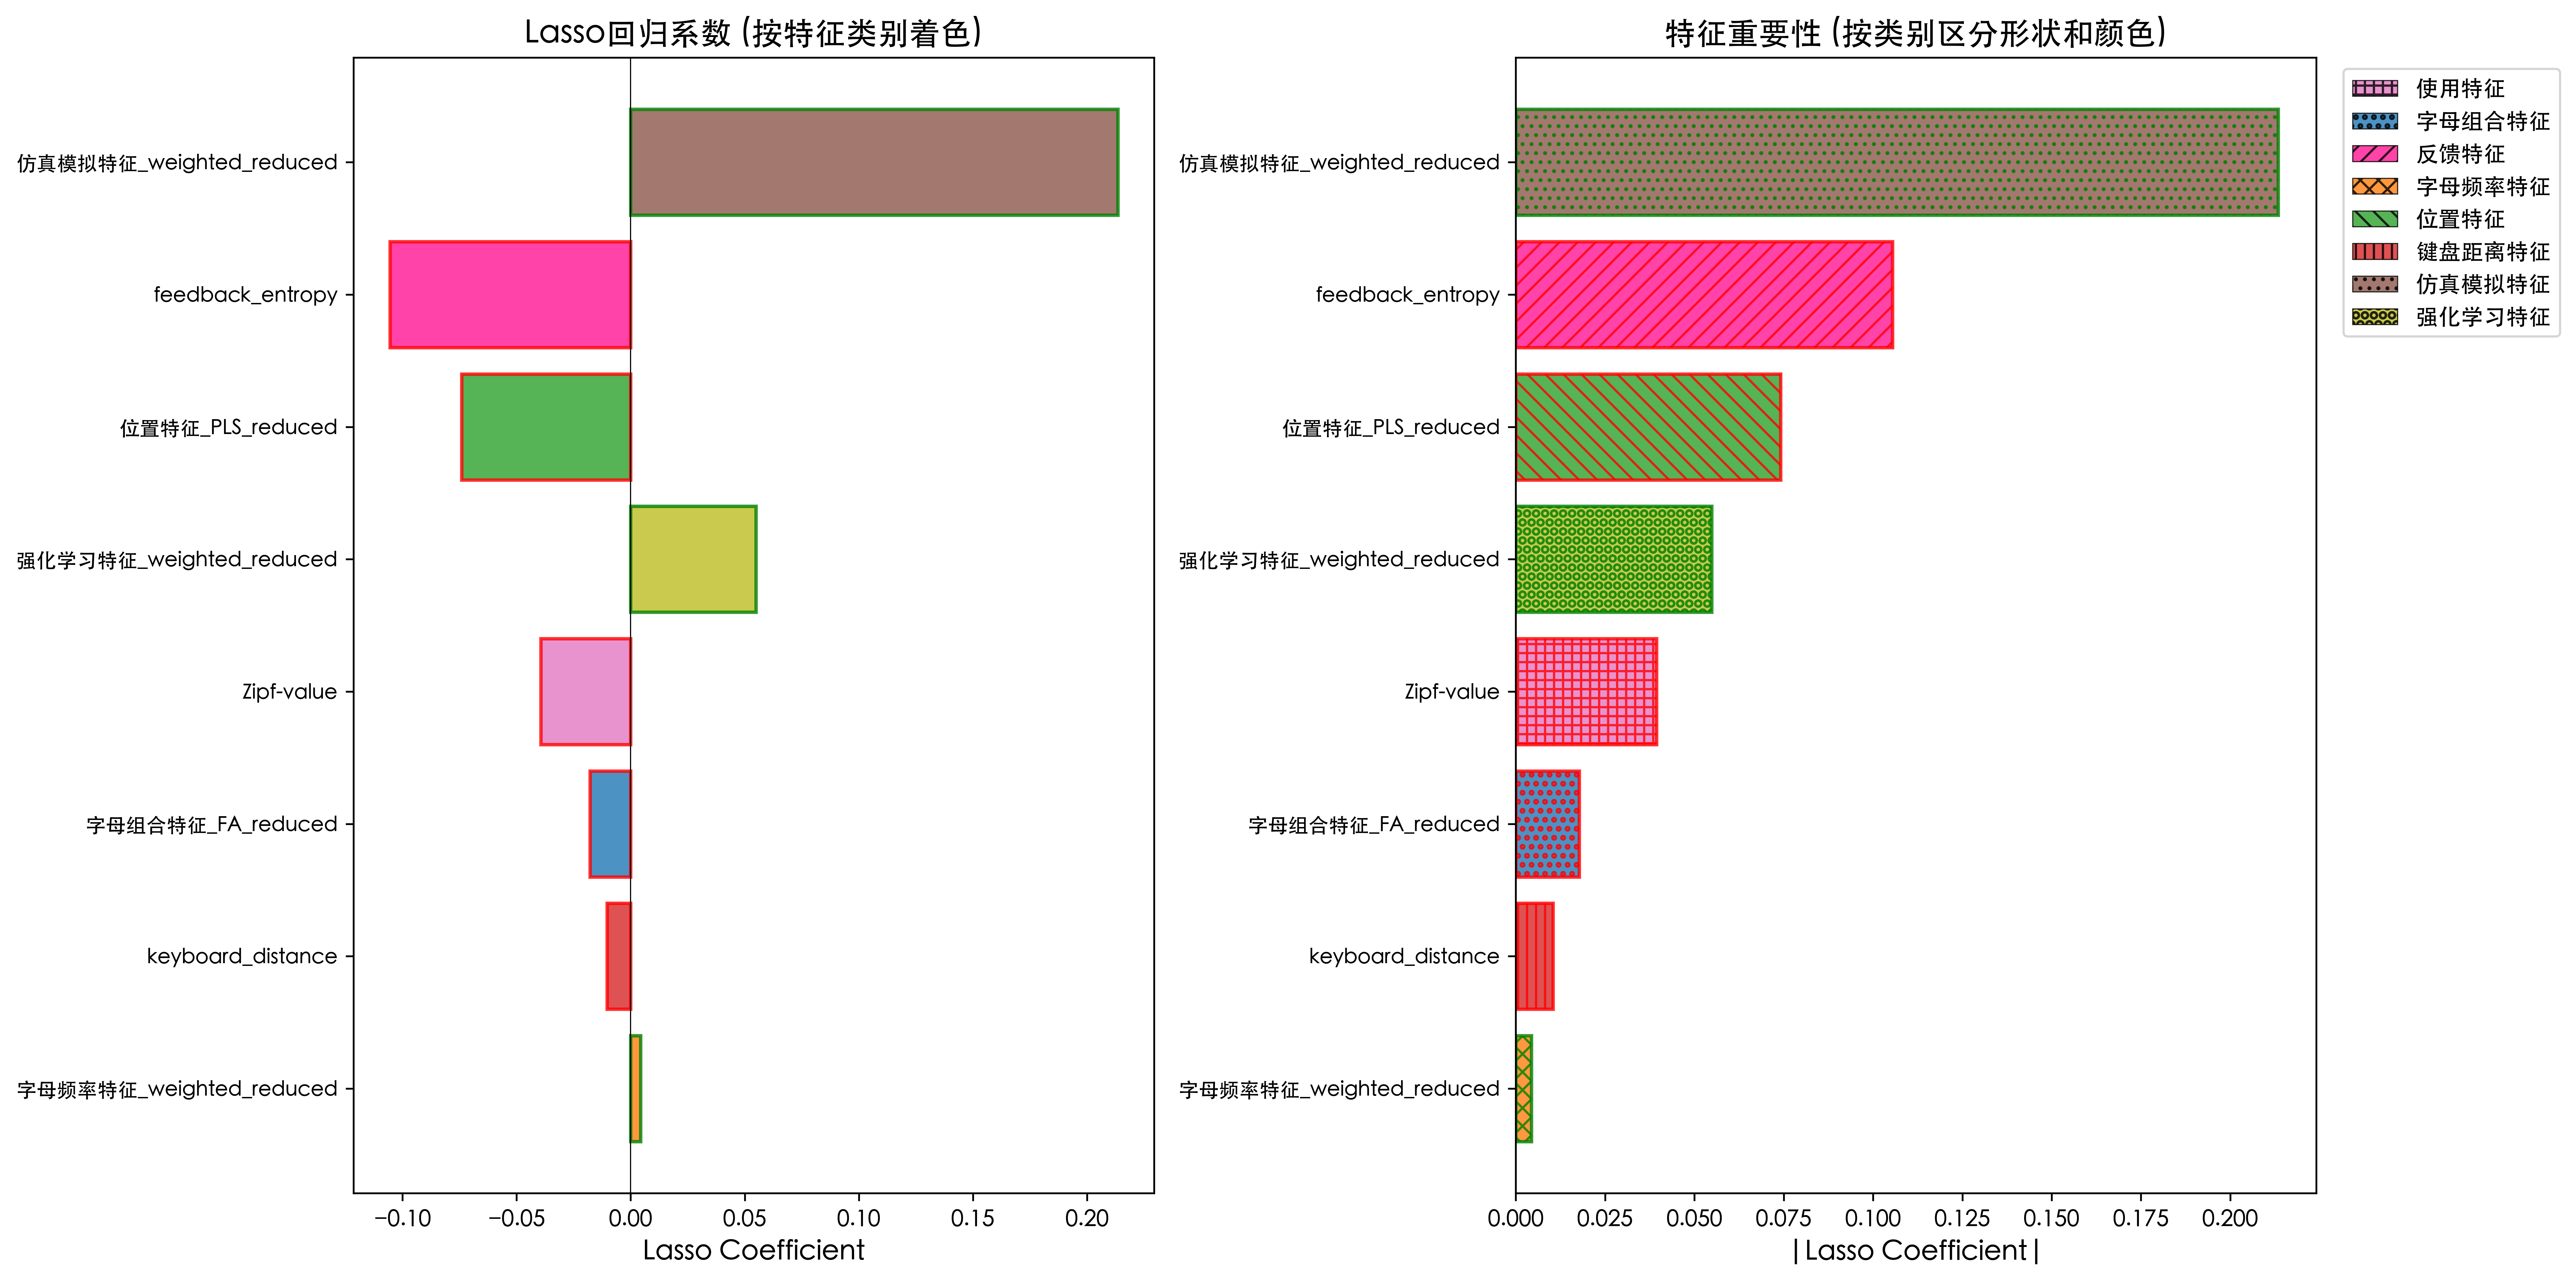


图例说明:
- 颜色区分特征类别
- 填充图案(hatch)进一步区分类别
- 绿色边框=正相关系数, 红色边框=负相关系数

特征类别统计:
  仿真模拟特征: 1 个特征
  反馈特征: 1 个特征
  位置特征: 1 个特征
  强化学习特征: 1 个特征
  使用特征: 1 个特征
  字母组合特征: 1 个特征
  键盘距离特征: 1 个特征
  字母频率特征: 1 个特征


In [13]:
## 步骤8: Lasso回归可视化（参照addOn.ipynb的方式）

# 从addOn.ipynb导入特征分类的颜色和标记定义
category_colors = {
    '使用特征': '#e377c2',
    '字母组合特征': '#1f77b4',
    '反馈特征': '#ff1493',        # 深粉红色 - 反馈熵
    '音节特征': '#17becf',
    '字母频率特征': '#ff7f0e',
    '位置特征': '#2ca02c',
    '键盘距离特征': '#d62728',
    '语义特征': '#9467bd',
    '仿真模拟特征': '#8c564b',
    '熵特征': '#7f7f7f',
    '强化学习特征': '#bcbd22',
}

category_hatches = {
    '使用特征': '+++',
    '字母组合特征': 'ooo',
    '反馈特征': '///',            # 斜线图案（与音节特征相同，但颜色不同）
    '音节特征': '///',
    '字母频率特征': 'xxx',
    '位置特征': '\\\\\\',
    '键盘距离特征': '|||',
    '语义特征': '---',
    '仿真模拟特征': '...',
    '熵特征': '***',
    '强化学习特征': 'OOO',
}

category_styles = {
    '使用特征': {'color': '#e377c2', 'linestyle': '-.', 'linewidth': 2.0},
    '字母组合特征': {'color': '#1f77b4', 'linestyle': '-', 'linewidth': 2.0},
    '反馈特征': {'color': '#ff1493', 'linestyle': '--', 'linewidth': 2.0},  # 深粉红色，虚线
    '音节特征': {'color': '#17becf', 'linestyle': '--', 'linewidth': 2.0},
    '字母频率特征': {'color': '#ff7f0e', 'linestyle': '--', 'linewidth': 2.0},
    '位置特征': {'color': '#2ca02c', 'linestyle': '-.', 'linewidth': 2.0},
    '键盘距离特征': {'color': '#d62728', 'linestyle': ':', 'linewidth': 2.5},
    '语义特征': {'color': '#9467bd', 'linestyle': '-', 'linewidth': 1.5},
    '仿真模拟特征': {'color': '#8c564b', 'linestyle': '--', 'linewidth': 1.5},
    '熵特征': {'color': '#7f7f7f', 'linestyle': ':', 'linewidth': 1.5},
    '强化学习特征': {'color': '#bcbd22', 'linestyle': '-', 'linewidth': 2.5},
}

# 收集不需要降维的特征（单特征组）
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)

# 合并所有特征（降维特征 + 不需要降维的原始特征）
all_features_for_prediction = new_features + non_reduced_features

if len(all_features_for_prediction) > 0:
    # 为特征分配类别（根据特征名称推断）
    def get_feature_category(feature_name):
        """根据特征名称推断其所属的原始特征组"""
        # 降维特征命名格式：{group_name}_PCA_reduced, {group_name}_FA_reduced（只使用无监督方法）
        for group_name in feature_categories.keys():
            if feature_name.startswith(group_name + '_'):
                return group_name
            # 对于原始特征，直接检查是否在特征组中
            if feature_name in feature_categories.get(group_name, []):
                return group_name
        return '其他'
    
    # 可视化特征重要性
    plt.rcParams['font.family'] = 'Heiti TC'
    fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=600)
    
    # 只显示非零系数的特征
    nonzero_df = coef_df[coef_df['coefficient'] != 0].copy()
    
    # 为每个特征分配类别和颜色
    nonzero_df['category'] = nonzero_df['feature'].apply(get_feature_category)
    nonzero_df['color'] = nonzero_df['category'].map(category_colors)
    
    # 修复 nan 值问题：为未分类的特征分配默认颜色
    nonzero_df['color'] = nonzero_df['color'].fillna('gray')
    
    # 图1: 按系数值排序的条形图（使用不同颜色区分类别）
    ax1 = axes[0]
    colors1 = ['green' if x > 0 else 'red' for x in nonzero_df['coefficient']]
    bars1 = ax1.barh(range(len(nonzero_df)), nonzero_df['coefficient'], 
                     color=nonzero_df['color'], alpha=0.8, edgecolor=colors1, linewidth=1.5)
    
    ax1.set_yticks(range(len(nonzero_df)))
    ax1.set_yticklabels(nonzero_df['feature'], fontsize=9)
    ax1.set_xlabel('Lasso Coefficient', fontsize=12)
    ax1.set_title('Lasso回归系数 (按特征类别着色)', fontsize=14)
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    ax1.invert_yaxis()
    
    # 图2: 按绝对值排序的条形图（使用不同形状区分类别）
    ax2 = axes[1]
    sorted_by_abs = nonzero_df.sort_values('abs_coefficient', ascending=True)
    
    # 绘制柱状图
    y_positions = range(len(sorted_by_abs))
    for i, (idx, row) in enumerate(sorted_by_abs.iterrows()):
        category = row['category']
        color = row['color']
        hatch = category_hatches.get(category, 'xxx')
        edge_color = 'green' if row['coefficient'] > 0 else 'red'
        
        ax2.barh(i, row['abs_coefficient'], 
                 color=color, alpha=0.8, 
                 hatch=hatch, edgecolor=edge_color, linewidth=1.5)
    
    ax2.set_yticks(y_positions)
    ax2.set_yticklabels(sorted_by_abs['feature'], fontsize=9)
    ax2.set_xlabel('|Lasso Coefficient|', fontsize=12)
    ax2.set_title('特征重要性 (按类别区分形状和颜色)', fontsize=14)
    
    # 添加图例
    legend_elements = []
    for category, color in category_colors.items():
        if category in sorted_by_abs['category'].values:
            hatch = category_hatches.get(category, '')
            legend_elements.append(
                plt.Rectangle((0, 0), 1, 1, facecolor=color, alpha=0.8, 
                             hatch=hatch, edgecolor='black', linewidth=0.5, label=category)
            )
    
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout()
    
    # 创建输出目录
    os.makedirs('pictures', exist_ok=True)
    plt.savefig('pictures/lasso_reduced_features_importance_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 打印类别统计
    print("\n图例说明:")
    print("- 颜色区分特征类别")
    print("- 填充图案(hatch)进一步区分类别")
    print("- 绿色边框=正相关系数, 红色边框=负相关系数")
    print("\n特征类别统计:")
    category_counts = nonzero_df['category'].value_counts()
    for category, count in category_counts.items():
        print(f"  {category}: {count} 个特征")
else:
    print("⚠️ 没有降维特征可用于可视化")


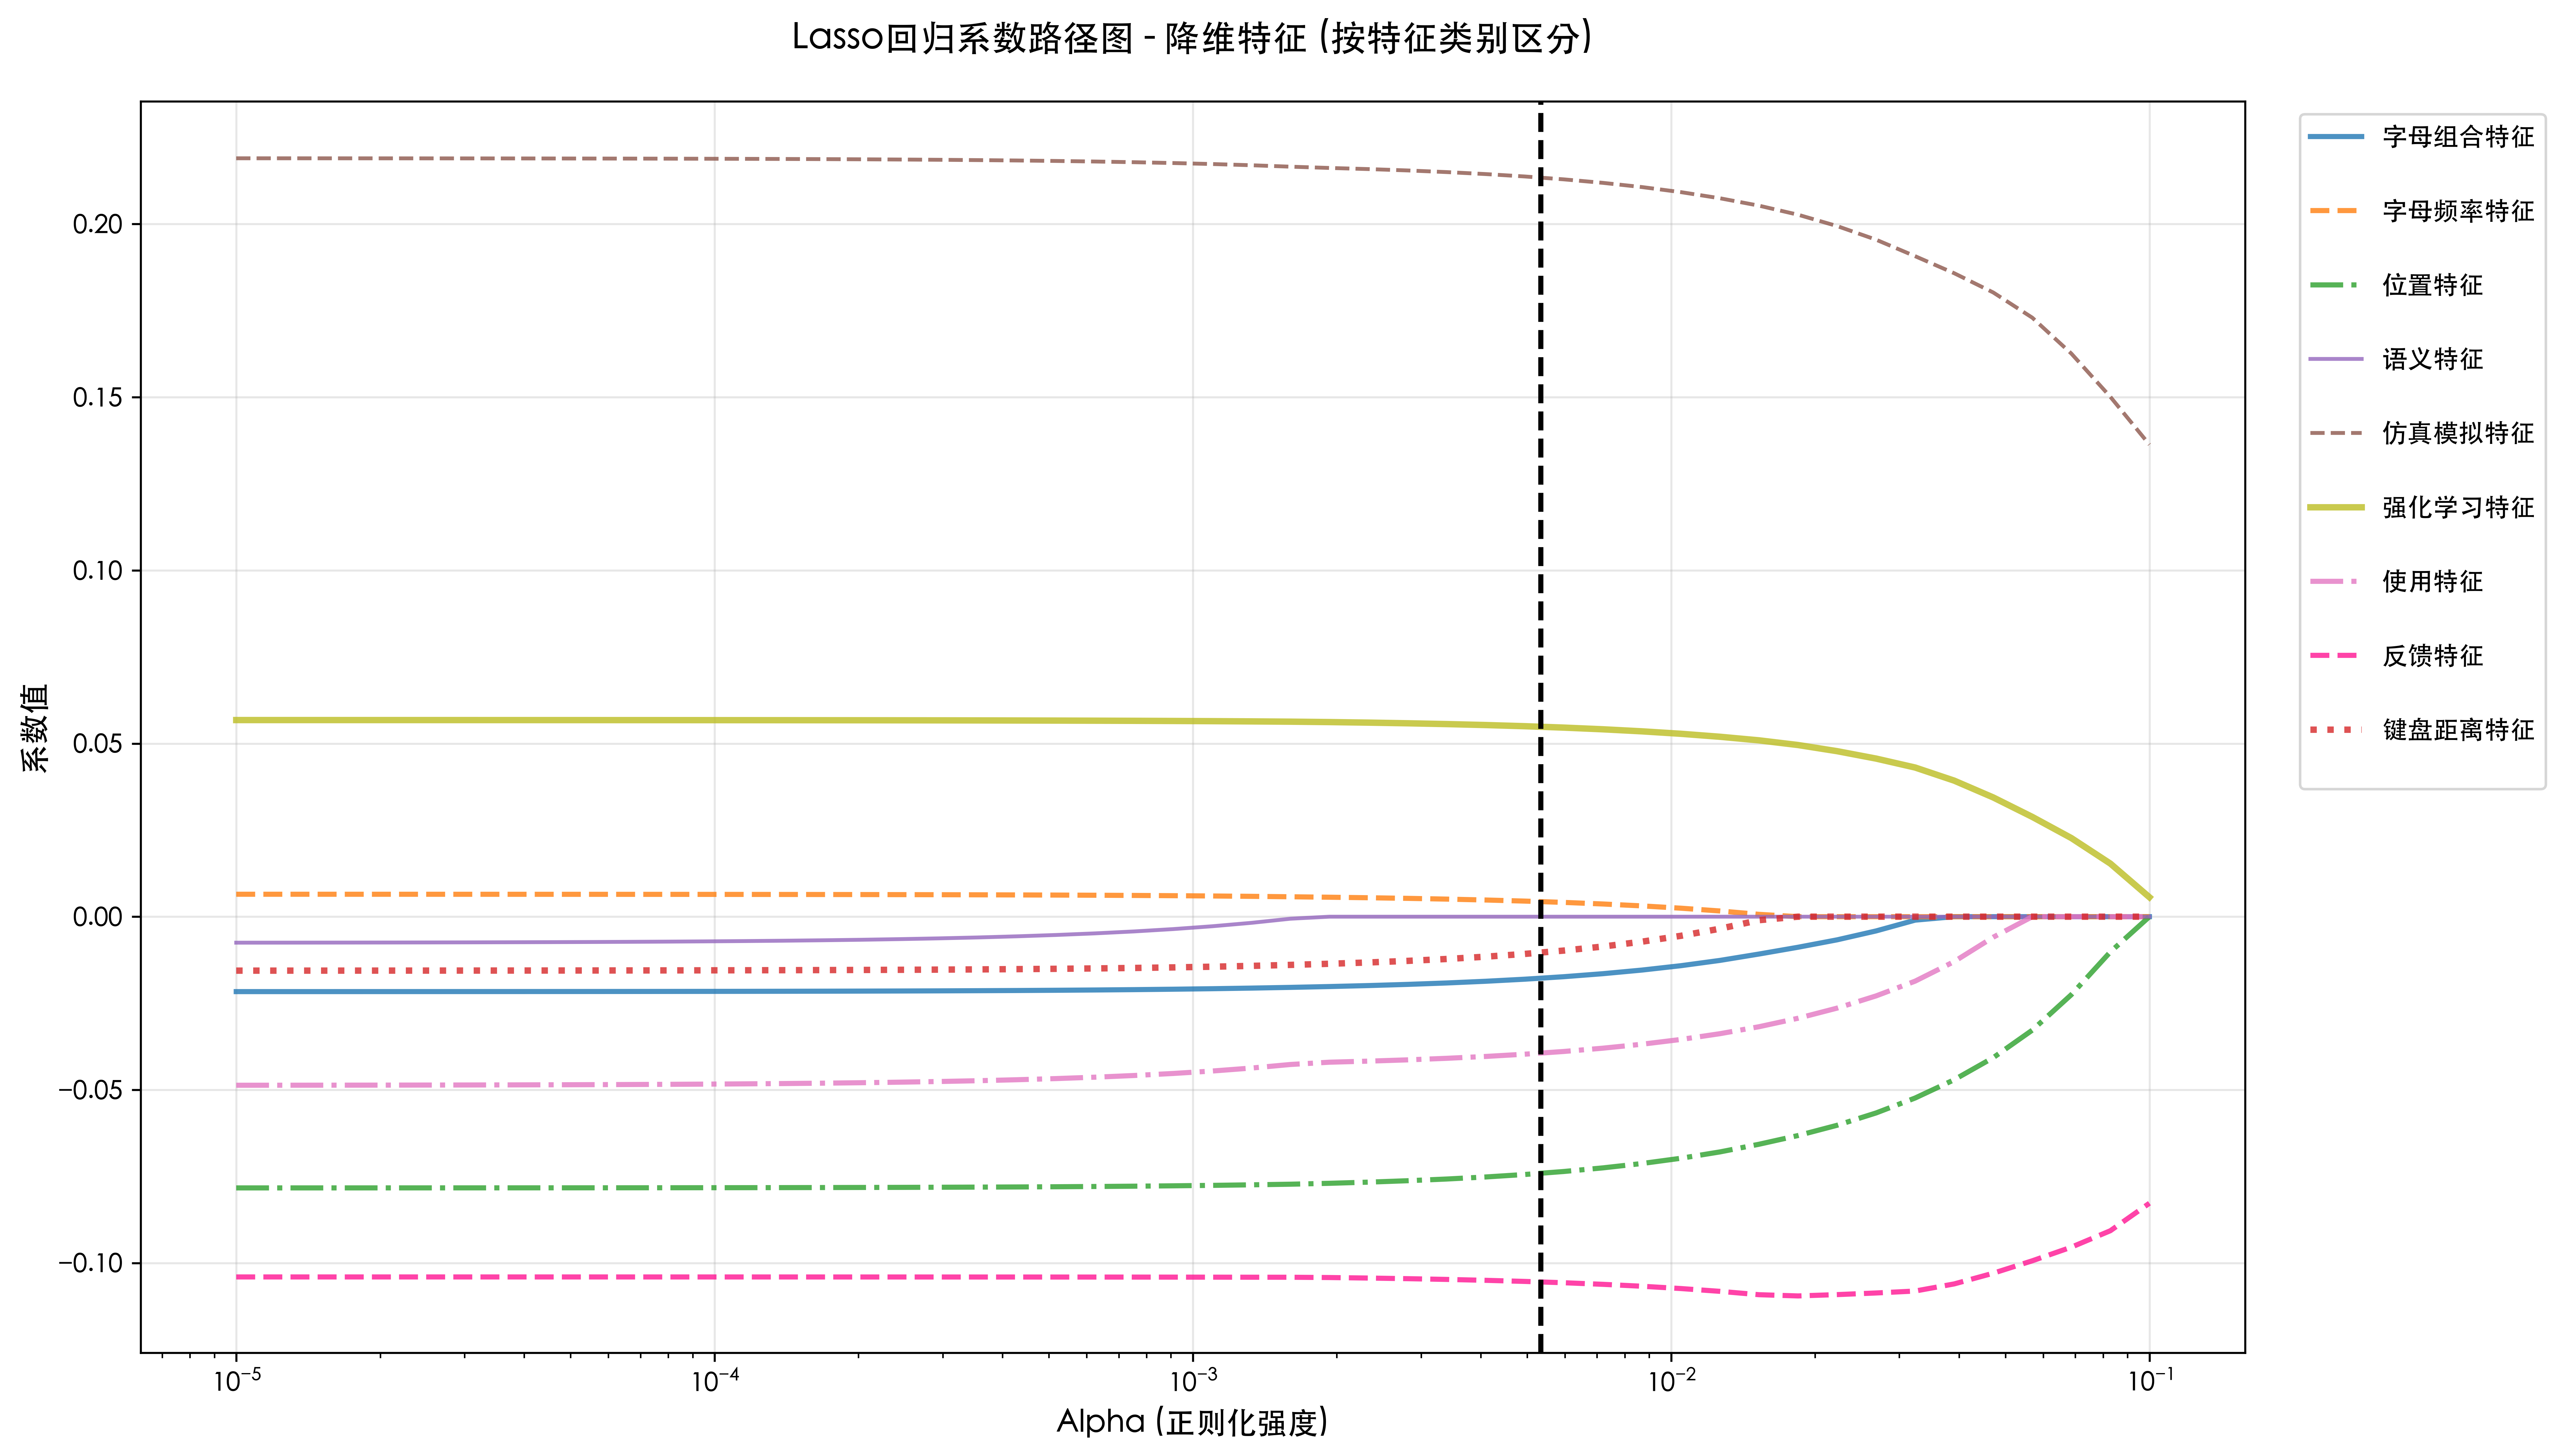


特征类别统计:
  使用特征: 0 个降维特征, 1 个原始特征
  字母组合特征: 1 个降维特征, 0 个原始特征
  反馈特征: 0 个降维特征, 1 个原始特征
  字母频率特征: 1 个降维特征, 0 个原始特征
  位置特征: 1 个降维特征, 0 个原始特征
  键盘距离特征: 0 个降维特征, 1 个原始特征
  语义特征: 1 个降维特征, 0 个原始特征
  仿真模拟特征: 1 个降维特征, 0 个原始特征
  强化学习特征: 1 个降维特征, 0 个原始特征


In [14]:
## 步骤9: Lasso回归系数路径图（参照addOn.ipynb的方式）

# 收集不需要降维的特征（单特征组）
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)

# 合并所有特征（降维特征 + 不需要降维的原始特征）
all_features_for_prediction = new_features + non_reduced_features

if len(all_features_for_prediction) > 0 and 'lasso_final' in locals():
    # 不同alpha值下的系数路径图
    alphas = np.logspace(-5, -1, 50)
    coefs = []
    
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train_scaled, y_train_final)
        coefs.append(lasso.coef_)
    
    coefs = np.array(coefs)
    
    # 绘制系数路径
    plt.figure(figsize=(14, 8), dpi=600)
    
    # 为特征分配类别函数
    def get_feature_category(feature_name):
        """根据特征名称推断其所属的原始特征组"""
        # 降维特征命名格式：{group_name}_PCA_reduced, {group_name}_FA_reduced（只使用无监督方法）
        for group_name in feature_categories.keys():
            if feature_name.startswith(group_name + '_'):
                return group_name
            # 对于原始特征，直接检查是否在特征组中
            if feature_name in feature_categories.get(group_name, []):
                return group_name
        return '其他'
    
    # 为每个特征分配到对应的类别
    for i, feature in enumerate(all_features_for_prediction):
        # 找到特征所属的类别
        category = get_feature_category(feature)
        
        if category and category in category_styles:
            style = category_styles[category]
            plt.plot(alphas, coefs[:, i], label=f"{feature} ({category})", 
                    color=style['color'], linestyle=style['linestyle'], 
                    linewidth=style['linewidth'], alpha=0.8)
        else:
            # 未分类的特征使用默认样式
            plt.plot(alphas, coefs[:, i], label=feature, linewidth=1.5, alpha=0.6)
    
    plt.xscale('log')
    plt.xlabel('Alpha (正则化强度)', fontsize=12)
    plt.ylabel('系数值', fontsize=12)
    plt.title('Lasso回归系数路径图 - 降维特征 (按特征类别区分)', fontsize=14, pad=20)
    plt.axvline(x=analysis_alpha, color='black', linestyle='--', 
                label=f'选定alpha={analysis_alpha:.6f}', linewidth=2)
    
    # 创建图例，按类别分组
    handles, labels = plt.gca().get_legend_handles_labels()
    # 按类别重新组织图例
    category_handles = {}
    for handle, label in zip(handles, labels):
        # 提取类别名
        if '(' in label and ')' in label:
            category = label.split('(')[-1].strip(')')
            if category not in category_handles:
                category_handles[category] = []
            category_handles[category].append(handle)
    
    # 创建新的图例
    legend_elements = []
    for category, handles_list in category_handles.items():
        # 使用第一个handle的颜色和样式
        if handles_list:
            legend_elements.append(handles_list[0])
            legend_elements.append(plt.Line2D([0], [0], color='white', linewidth=0))  # 空白分隔
    
    plt.legend(legend_elements, 
               [f"{cat}" if i % 2 == 0 else "" for i, cat in enumerate(sum([[k] * 2 for k in category_handles.keys()], []))],
               bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=10, frameon=True)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pictures/lasso_reduced_features_coefficient_path_by_category.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 打印类别统计
    print("\n特征类别统计:")
    for category, features in feature_categories.items():
        count_reduced = len([f for f in new_features if category in f])
        count_original = len([f for f in non_reduced_features if f in features])
        if count_reduced > 0 or count_original > 0:
            print(f"  {category}: {count_reduced} 个降维特征, {count_original} 个原始特征")
else:
    print("⚠️ 没有降维特征可用于系数路径图")


In [15]:
## 步骤10: 保存Lasso回归分析结果

# 收集不需要降维的特征（单特征组）
non_reduced_features = []
for group_name, features in feature_categories.items():
    existing_features = [f for f in features if f in X_train.columns]
    if len(existing_features) == 1:
        # 单特征组，直接保留
        feat = existing_features[0]
        if feat not in non_reduced_features:
            non_reduced_features.append(feat)

# 合并所有特征（降维特征 + 不需要降维的原始特征）
all_features_for_prediction = new_features + non_reduced_features

if len(all_features_for_prediction) > 0 and 'coef_df' in locals():
    # 汇总表格
    print("\n" + "=" * 80)
    print("Lasso回归分析结果汇总（降维特征）")
    print("=" * 80)
    
    summary_df = coef_df[['feature', 'coefficient', 'abs_coefficient']].copy()
    summary_df['rank'] = range(1, len(summary_df) + 1)
    summary_df['selected'] = summary_df['coefficient'] != 0
    summary_df = summary_df[['rank', 'feature', 'coefficient', 'abs_coefficient', 'selected']]
    summary_df.columns = ['排名', '特征变量', '系数', '系数绝对值', '被选择']
    
    print(summary_df.to_string(index=False))
    
    # 保存结果
    os.makedirs('data', exist_ok=True)
    summary_df.to_excel('data/lasso_reduced_features_importance.xlsx', index=False)
    print("\n✅ 结果已保存到 data/lasso_reduced_features_importance.xlsx")
    
    # 对比分析：降维特征 vs 原始特征
    print("\n" + "=" * 80)
    print("降维特征 vs 原始特征对比")
    print("=" * 80)
    print(f"降维特征数量: {len(new_features)}")
    print(f"不需要降维的原始特征数量: {len(non_reduced_features)}")
    print(f"总特征数量: {len(all_features_for_prediction)}")
    print(f"被Lasso选择的特征数: {(coef_df['coefficient'] != 0).sum()}")
    print(f"选择率: {(coef_df['coefficient'] != 0).sum() / len(all_features_for_prediction) * 100:.1f}%")
    print(f"  - 降维特征选择率: {(coef_df[coef_df['feature'].isin(new_features)]['coefficient'] != 0).sum() / len(new_features) * 100:.1f}%")
    print(f"  - 原始特征选择率: {(coef_df[coef_df['feature'].isin(non_reduced_features)]['coefficient'] != 0).sum() / len(non_reduced_features) * 100:.1f}%")
    print(f"训练集R²得分: {lasso_final.score(X_train_scaled, y_train_final):.4f}")
    print(f"测试集R²得分: {lasso_final.score(X_test_scaled, y_test_final):.4f}")
    print("=" * 80)
else:
    print("⚠️ 没有Lasso回归结果可保存")



Lasso回归分析结果汇总（降维特征）
 排名                    特征变量        系数    系数绝对值   被选择
  1 仿真模拟特征_weighted_reduced  0.213427 0.213427  True
  2        feedback_entropy -0.105471 0.105471  True
  3        位置特征_PLS_reduced -0.074112 0.074112  True
  4 强化学习特征_weighted_reduced  0.054848 0.054848  True
  5              Zipf-value -0.039405 0.039405  True
  6       字母组合特征_FA_reduced -0.017775 0.017775  True
  7       keyboard_distance -0.010381 0.010381  True
  8 字母频率特征_weighted_reduced  0.004356 0.004356  True
  9   语义特征_weighted_reduced  0.000000 0.000000 False

✅ 结果已保存到 data/lasso_reduced_features_importance.xlsx

降维特征 vs 原始特征对比
降维特征数量: 6
不需要降维的原始特征数量: 3
总特征数量: 9
被Lasso选择的特征数: 8
选择率: 88.9%
  - 降维特征选择率: 83.3%
  - 原始特征选择率: 100.0%
训练集R²得分: 0.6273
测试集R²得分: 0.6503


In [16]:
## 步骤11: 保存降维模型（用于对新数据进行降维）

import pickle
import os

# 创建模型保存目录
os.makedirs('models/reduction_models', exist_ok=True)

# 保存降维模型
if 'all_reduction_results' in locals() and len(all_reduction_results) > 0:
    # 准备保存的数据结构
    reduction_models_to_save = {}
    
    for group_name, group_data in all_reduction_results.items():
        features = group_data['features']
        results = group_data['results']
        
        # 找到最优方法
        best_method = None
        best_r2 = -np.inf
        
        for method_name, method_result in results.items():
            if method_result is not None and 'evaluation' in method_result:
                r2 = method_result['evaluation'].get('r2_mean', -np.inf)
                if r2 > best_r2:
                    best_r2 = r2
                    best_method = method_name
        
        if best_method and results[best_method] is not None:
            method_result = results[best_method]
            
            # 保存训练时的中位数（用于填充缺失值）
            X_train = df[features].copy()
            median_values = X_train.median().to_dict()
            
            # 保存模型信息
            reduction_models_to_save[group_name] = {
                'features': features,  # 原始特征列表
                'method': best_method,  # 最优方法
                'scaler': method_result.get('scaler'),  # 标准化器
                'median_values': median_values,  # 训练时的中位数（用于填充缺失值）
                'feature_name': f'{group_name}_{best_method}_reduced' if best_method == 'PCA' else (
                    f'{group_name}_FA_reduced' if best_method == 'Factor Analysis' else (
                    f'{group_name}_CCA_reduced' if best_method == 'CCA' else (
                    f'{group_name}_PLS_reduced' if best_method == 'PLS' else
                    f'{group_name}_weighted_reduced'
                ))),
            }
            
            # 根据方法保存相应的模型对象（支持所有方法）
            if best_method == 'PCA':
                reduction_models_to_save[group_name]['pca'] = method_result.get('pca')
                reduction_models_to_save[group_name]['n_components'] = method_result.get('n_components', 1)
            elif best_method == 'Factor Analysis':
                reduction_models_to_save[group_name]['fa'] = method_result.get('fa')
                reduction_models_to_save[group_name]['n_components'] = method_result.get('n_components', 1)
            elif best_method == 'CCA':
                reduction_models_to_save[group_name]['cca'] = method_result.get('cca')
                reduction_models_to_save[group_name]['scaler_y'] = method_result.get('scaler_y')
                reduction_models_to_save[group_name]['n_components'] = method_result.get('n_components', 1)
            elif best_method == 'PLS':
                reduction_models_to_save[group_name]['pls'] = method_result.get('pls')
                reduction_models_to_save[group_name]['n_components'] = method_result.get('n_components', 1)
            elif best_method == 'Supervised Linear Weighted':
                reduction_models_to_save[group_name]['weights'] = method_result.get('weights')
    
    # 保存单特征组的信息（不需要降维的特征）
    non_reduced_info = {}
    for group_name, features in feature_categories.items():
        existing_features = [f for f in features if f in df.columns]
        if len(existing_features) == 1:
            non_reduced_info[group_name] = {
                'feature': existing_features[0],
                'feature_name': existing_features[0]
            }
    
    # 保存所有信息
    models_save_path = 'models/reduction_models/reduction_models.pkl'
    with open(models_save_path, 'wb') as f:
        pickle.dump({
            'reduction_models': reduction_models_to_save,
            'non_reduced_features': non_reduced_info,
            'feature_categories': feature_categories
        }, f)
    
    print("="*80)
    print("✅ 降维模型已保存")
    print("="*80)
    print(f"保存路径: {models_save_path}")
    print(f"降维模型数量: {len(reduction_models_to_save)}")
    print(f"不需要降维的特征数量: {len(non_reduced_info)}")
    print("\n保存的降维模型:")
    for group_name, model_info in reduction_models_to_save.items():
        print(f"  - {group_name}: {model_info['method']} -> {model_info['feature_name']}")
    print("\n不需要降维的特征:")
    for group_name, info in non_reduced_info.items():
        print(f"  - {group_name}: {info['feature']}")
    print("="*80)
else:
    print("⚠️ 没有降维结果可保存，请先运行降维分析")


✅ 降维模型已保存
保存路径: models/reduction_models/reduction_models.pkl
降维模型数量: 6
不需要降维的特征数量: 3

保存的降维模型:
  - 字母组合特征: Factor Analysis -> 字母组合特征_FA_reduced
  - 字母频率特征: Supervised Linear Weighted -> 字母频率特征_weighted_reduced
  - 位置特征: PLS -> 位置特征_PLS_reduced
  - 语义特征: Supervised Linear Weighted -> 语义特征_weighted_reduced
  - 仿真模拟特征: Supervised Linear Weighted -> 仿真模拟特征_weighted_reduced
  - 强化学习特征: Supervised Linear Weighted -> 强化学习特征_weighted_reduced

不需要降维的特征:
  - 使用特征: Zipf-value
  - 反馈特征: feedback_entropy
  - 键盘距离特征: keyboard_distance


In [17]:
## 步骤12: 对新数据进行降维（无需预测值）

def reduce_new_data(new_data, models_path='models/reduction_models/reduction_models.pkl'):
    """
    对新数据进行降维（无需目标变量）
    
    参数:
        new_data: pandas DataFrame，包含原始特征列
        models_path: 保存的模型文件路径
    
    返回:
        reduced_data: pandas DataFrame，包含降维后的特征
    """
    import pickle
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    
    # 加载模型
    with open(models_path, 'rb') as f:
        saved_models = pickle.load(f)
    
    reduction_models = saved_models['reduction_models']
    non_reduced_info = saved_models['non_reduced_features']
    feature_categories = saved_models['feature_categories']
    
    # 存储降维后的特征
    reduced_features_dict = {}
    
    print("="*80)
    print("对新数据进行降维")
    print("="*80)
    
    # 处理需要降维的特征组
    for group_name, model_info in reduction_models.items():
        features = model_info['features']
        method = model_info['method']
        feature_name = model_info['feature_name']
        scaler = model_info['scaler']
        
        # 检查新数据中是否有所有需要的特征
        missing_features = [f for f in features if f not in new_data.columns]
        if missing_features:
            print(f"⚠️ {group_name}: 缺少特征 {missing_features}，跳过")
            continue
        
        # 提取特征数据
        X_new = new_data[features].copy()
        
        # 处理缺失值（使用训练时的中位数填充）
        median_values = model_info.get('median_values', {})
        for feat in features:
            if feat in X_new.columns:
                if X_new[feat].isna().any():
                    fill_value = median_values.get(feat, X_new[feat].median())
                    X_new[feat] = X_new[feat].fillna(fill_value)
                    if X_new[feat].isna().any():  # 如果中位数也是NaN，用0填充
                        X_new[feat] = X_new[feat].fillna(0)
        
        try:
            # 标准化
            X_new_scaled = scaler.transform(X_new)
            
            # 根据方法进行降维（支持所有方法）
            if method == 'PCA':
                pca = model_info['pca']
                n_components = model_info.get('n_components', 1)
                X_reduced = pca.transform(X_new_scaled)
                # 只取第一主成分
                if X_reduced.ndim > 1:
                    reduced_feature = X_reduced[:, 0]
                else:
                    reduced_feature = X_reduced
                    
            elif method == 'Factor Analysis':
                fa = model_info['fa']
                X_reduced = fa.transform(X_new_scaled)
                if X_reduced.ndim > 1:
                    reduced_feature = X_reduced[:, 0]
                else:
                    reduced_feature = X_reduced
                    
            elif method == 'CCA':
                # CCA需要目标变量，但新数据没有，所以使用训练时的CCA模型进行transform
                # 注意：这需要提供一个虚拟的y，但结果可能不是最优的
                cca = model_info['cca']
                # 对于新数据，CCA的transform需要y，但我们没有，所以使用一个零向量
                # 这会导致结果不准确，建议对于新数据使用PCA或FA
                print(f"⚠️ {group_name}: CCA需要目标变量，新数据降维可能不准确")
                y_dummy = np.zeros((len(X_new_scaled), 1))
                X_reduced, _ = cca.transform(X_new_scaled, y_dummy)
                if X_reduced.ndim > 1:
                    reduced_feature = X_reduced[:, 0]
                else:
                    reduced_feature = X_reduced
                    
            elif method == 'PLS':
                pls = model_info['pls']
                X_reduced = pls.transform(X_new_scaled)
                if X_reduced.ndim > 1:
                    reduced_feature = X_reduced[:, 0]
                else:
                    reduced_feature = X_reduced
                    
            elif method == 'Supervised Linear Weighted':
                weights = model_info['weights']
                reduced_feature = X_new_scaled @ weights
                    
            else:
                print(f"⚠️ {group_name}: 未知方法 {method}，跳过")
                continue
            
            # 保存降维后的特征
            reduced_features_dict[feature_name] = reduced_feature
            print(f"✅ {group_name}: {method} -> {feature_name} (形状: {reduced_feature.shape})")
            
        except Exception as e:
            print(f"❌ {group_name}: 降维失败 - {str(e)}")
            continue
    
    # 处理不需要降维的特征（单特征组）
    for group_name, info in non_reduced_info.items():
        feature = info['feature']
        if feature in new_data.columns:
            reduced_features_dict[feature] = new_data[feature].values
            print(f"✅ {group_name}: 直接保留原始特征 '{feature}'")
        else:
            print(f"⚠️ {group_name}: 缺少特征 '{feature}'，跳过")
    
    # 创建结果DataFrame
    if reduced_features_dict:
        # 确保所有特征长度一致
        lengths = [len(v) if hasattr(v, '__len__') else 1 for v in reduced_features_dict.values()]
        if len(set(lengths)) == 1:
            reduced_df = pd.DataFrame(reduced_features_dict)
        else:
            # 如果长度不一致，可能是单条数据
            reduced_df = pd.DataFrame({k: [v] if not hasattr(v, '__len__') or len(v) == 1 else v 
                                      for k, v in reduced_features_dict.items()})
        
        print("\n" + "="*80)
        print("✅ 降维完成")
        print("="*80)
        print(f"降维后特征数量: {len(reduced_df.columns)}")
        print(f"数据点数量: {len(reduced_df)}")
        print(f"\n降维后的特征列表:")
        for col in reduced_df.columns:
            print(f"  - {col}")
        print("="*80)
        
        return reduced_df
    else:
        print("\n❌ 没有成功降维的特征")
        return None

# 示例：对新数据进行降维
# 假设你有一条新数据
# new_data_example = pd.DataFrame({
#     'letter_entropy': [2.5],
#     'hamming_neighbors': [5],
#     'num_consonants': [3],
#     # ... 其他特征
# })
# reduced_new_data = reduce_new_data(new_data_example)
# print(reduced_new_data)


In [18]:
## 使用示例：对新数据进行降维

# 示例1: 单条新数据
print("="*80)
print("示例1: 对新数据进行降维")
print("="*80)

# 假设你有一条新数据（只需要原始特征，不需要autoencoder_value）
# 注意：新数据需要包含所有训练时使用的原始特征
example_new_data = pd.DataFrame({
    'letter_entropy': [2.32],
    'hamming_neighbors': [6],
    'num_consonants': [3],
    'max_consecutive_vowels': [1],
    'max_consecutive_consonants': [2],
    'starts_with_vowel': [0],
    'ends_with_vowel': [0],
    'letter_freq_mean': [0.05],
    'letter_freq_min': [0.03],
    'letter_commonness': [4.5],
    'contains_y': [0],
    'has_double_letter': [0],
    'scrabble_score': [10],
    'has_common_suffix': [1],
    'has_common_prefix': [0],
    'num_rare_letters': [0],
    'position_rarity': [15.0],
    'positional_freq_mean': [0.08],
    'positional_freq_min': [0.05],
    'positional_fit': [8.5],
    'keyboard_distance': [4.2],
    'semantic_neighbors_count': [0],
    'semantic_density': [0.35],
    'semantic_difficulty': [0.65],
    'semantic_distance': [0.5],
    'semantic_distance_to_center': [6.5],
    'Zipf-value': [3.5],
    'feedback_entropy': [4.8],
    'position_self_entropy': [17.5],
    'position_self_entropy_2_letters': [5.6],
    # 仿真模拟特征（示例值）
    'mean_simulate_random': [4.5],
    '1_try_simulate_random': [0.0],
    '2_try_simulate_random': [0.01],
    '3_try_simulate_random': [0.05],
    '4_try_simulate_random': [0.15],
    '5_try_simulate_random': [0.25],
    '6_try_simulate_random': [0.30],
    '7_try_simulate_random': [0.24],
    'mean_simulate_freq': [4.2],
    '1_try_simulate_freq': [0.0],
    '2_try_simulate_freq': [0.02],
    '3_try_simulate_freq': [0.10],
    '4_try_simulate_freq': [0.25],
    '5_try_simulate_freq': [0.30],
    '6_try_simulate_freq': [0.20],
    '7_try_simulate_freq': [0.13],
    'mean_simulate_entropy': [4.0],
    '1_try_simulate_entropy': [0.0],
    '2_try_simulate_entropy': [0.01],
    '3_try_simulate_entropy': [0.12],
    '4_try_simulate_entropy': [0.40],
    '5_try_simulate_entropy': [0.35],
    '6_try_simulate_entropy': [0.10],
    '7_try_simulate_entropy': [0.02],
    # 强化学习特征（示例值）
    'rl_expected_steps_low_training': [3.8],
    'rl_1_try_low_training': [0.0],
    'rl_2_try_low_training': [0.10],
    'rl_3_try_low_training': [0.35],
    'rl_4_try_low_training': [0.35],
    'rl_5_try_low_training': [0.15],
    'rl_6_try_low_training': [0.04],
    'rl_7_try_low_training': [0.01],
    'rl_expected_steps_high_training': [3.5],
    'rl_1_try_high_training': [0.0],
    'rl_2_try_high_training': [0.12],
    'rl_3_try_high_training': [0.40],
    'rl_4_try_high_training': [0.35],
    'rl_5_try_high_training': [0.10],
    'rl_6_try_high_training': [0.02],
    'rl_7_try_high_training': [0.01],
    'rl_expected_steps_little_training': [3.6],
    'rl_1_try_little_training': [0.0],
    'rl_2_try_little_training': [0.11],
    'rl_3_try_little_training': [0.38],
    'rl_4_try_little_training': [0.35],
    'rl_5_try_little_training': [0.12],
    'rl_6_try_little_training': [0.03],
    'rl_7_try_little_training': [0.01],
})

# 对新数据进行降维
try:
    reduced_example = reduce_new_data(example_new_data)
    if reduced_example is not None:
        print("\n降维后的数据:")
        print(reduced_example)
        print("\n降维后的数据形状:", reduced_example.shape)
        print("\n✅ 降维成功！现在可以使用这些降维后的特征进行预测了。")
    else:
        print("\n❌ 降维失败")
except FileNotFoundError:
    print("\n⚠️ 模型文件不存在，请先运行步骤11保存降维模型")
except Exception as e:
    print(f"\n❌ 发生错误: {str(e)}")
    import traceback
    traceback.print_exc()


示例1: 对新数据进行降维
对新数据进行降维
✅ 字母组合特征: Factor Analysis -> 字母组合特征_FA_reduced (形状: (1,))
✅ 字母频率特征: Supervised Linear Weighted -> 字母频率特征_weighted_reduced (形状: (1,))
✅ 位置特征: PLS -> 位置特征_PLS_reduced (形状: (1,))
✅ 语义特征: Supervised Linear Weighted -> 语义特征_weighted_reduced (形状: (1,))
✅ 仿真模拟特征: Supervised Linear Weighted -> 仿真模拟特征_weighted_reduced (形状: (1,))
✅ 强化学习特征: Supervised Linear Weighted -> 强化学习特征_weighted_reduced (形状: (1,))
✅ 使用特征: 直接保留原始特征 'Zipf-value'
✅ 反馈特征: 直接保留原始特征 'feedback_entropy'
✅ 键盘距离特征: 直接保留原始特征 'keyboard_distance'

✅ 降维完成
降维后特征数量: 9
数据点数量: 1

降维后的特征列表:
  - 字母组合特征_FA_reduced
  - 字母频率特征_weighted_reduced
  - 位置特征_PLS_reduced
  - 语义特征_weighted_reduced
  - 仿真模拟特征_weighted_reduced
  - 强化学习特征_weighted_reduced
  - Zipf-value
  - feedback_entropy
  - keyboard_distance

降维后的数据:
   字母组合特征_FA_reduced  字母频率特征_weighted_reduced  位置特征_PLS_reduced  \
0           0.080298                 0.823429          0.794643   

   语义特征_weighted_reduced  仿真模拟特征_weighted_reduced  强化学习特征_weighted_reduced  \
0  